In [1]:
import os
import json
import time
import math 
import pandas as pd
import numpy as np
import pickle
import itertools
from datetime import datetime, timezone
from scipy.signal import argrelextrema, medfilt, find_peaks_cwt, find_peaks
from scipy.optimize import curve_fit

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cycler, patches
#from matplotlib.colors import LogNorm

import lgdo.lh5_store as lh5
sto = lh5.LH5Store()

from legendmeta import LegendMetadata
meta_path = '/lfs/l1/legend/users/bianca/sw/legend-metadata'
lmeta = LegendMetadata(path=meta_path)

import pygama.math.peak_fitting as pgf
import pygama.math.histogram as pgh
import pygama.pargen.cuts as pcut
import pygama.pargen.energy_optimisation as om
from pygama.math.peak_fitting import extended_radford_pdf, radford_pdf, extended_gauss_step_pdf, gauss_step_pdf, goodness_of_fit

import calibration as cal
import AoE_cal_new as aoe_cal
import utility as ut

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
def pulser_tag(timestamp, t_pulser, gap = 0.01):
    pulser_idx = []
    for t in t_pulser:
        idx = np.where(np.abs(timestamp-t)<gap)[0]
        if len(idx)>0: pulser_idx.append(idx)
    pulser_idx = np.concatenate(pulser_idx)
    return np.array([False if i in pulser_idx else True for i in range(len(timestamp))])

In [3]:
def get_first_last_peaks(energySeries, detector_type, pulser = True, plot=False):
    """                                                                                                  
    find the most prominent peaks in a spectrum by looking for spikes in derivative of spectrum          
    energySeries: array of measured energies                                                             
    max_num_peaks = maximum number of most prominent peaks to find                                       
    return a histogram around the most prominent peak in a spectrum of a given percentage of width       
    """
    xlo = np.percentile(energySeries, 5)
    xhi = np.percentile(energySeries, 100)
    nb = 3000#int((xhi-xlo)/xpb)
    
    hist, bin_edges = np.histogram(energySeries, bins=np.linspace(xlo,xhi,nb))
    bin_centers = pgh.get_bin_centers(bin_edges)
    if pulser:
        xp = bin_centers[np.where(hist > hist.max()*0.01)][-1]
        hist = hist[np.where(bin_centers < xp-500)]
        bin_centers = bin_centers[np.where(bin_centers < xp-500)]

    peak_idxs, _ = find_peaks(hist,height=hist.max()/30,distance=50)
    peak_energies = bin_centers[peak_idxs]

    peak_max = bin_centers[np.argmax(hist)]
    peak_last = peak_energies[-1]
    print('peak_max', peak_max)
    print(peak_last)
    if (detector_type=="PPC" and peak_max > 1500):   
        #pp = peak_idxs[peak_energies < 1500]
        hh = hist[np.where(bin_centers < 1500)]
        peak_max = bin_centers[np.argmax(hh)]
    if peak_last == peak_max:
        hh = hist[np.where(bin_centers < peak_last-13500)]
        bb = bin_centers[np.where(bin_centers < peak_last-13500)]
        peak_max = bb[np.argmax(hh)]
        if peak_max < 1000:
            hh = hist[np.where((bin_centers>1500) & (bin_centers < 1700))]
            bb = bin_centers[np.where((bin_centers>1500) & (bin_centers < 1700))]
            peak_max = bb[np.argmax(hh)]
    elif detector_type=="ICPC" and peak_max < 1000:   
        hh = hist[np.where((bin_centers>1500) & (bin_centers < 1700))]
        bb = bin_centers[np.where((bin_centers>1500) & (bin_centers < 1700))]
        peak_max = bb[np.argmax(hh)]
    elif detector_type!="PPC" and peak_last <= peak_max + 2000:
        hh = hist[np.where(bin_centers > peak_max + 2000)]
        bb = bin_centers[np.where(bin_centers > peak_max + 2000)]
        peak_max = bb[np.argmax(hh)]
    print('peak_max', peak_max)  
    if plot:
        plt.figure(figsize=(12, 6.75), facecolor='white')
        plt.plot(bin_centers, hist, ds='steps', lw=1, c='b')
        #for e in peak_energies:
        #    plt.axvline(e, color="r", lw=1, alpha=0.6)
        plt.axvline(peak_max, color='r', lw=1, alpha=0.6,label='max peak')
        plt.axvline(peak_last, color='g', lw=1, alpha=0.6,label='last peak')
        plt.xlabel("Energy [uncal]", ha='right', x=1)
        plt.ylabel("Filtered Spectrum", ha='right', y=1)
        plt.yscale('log')
        plt.legend()
    return peak_max, peak_last

In [4]:
def get_FEP(energies):
    spectrum_end=20000
    hist, bin_edges = np.histogram(energies, np.linspace(0,spectrum_end,500))
    max_thr = 20
    start_search = np.where(hist>max_thr)[0][-1]-30
    bin_centr = (bin_edges[:-1] + bin_edges[1:]) / 2.
    peak = bin_centr[hist[start_search:].argmax()+start_search]
    delta_peak, delta_peak1, delta_peak2 = 300, 80, 80
    hist_peak, bins, var = pgh.get_hist(energies,dx=1,range=(peak-delta_peak, peak+delta_peak))
    bin_cs = (bins[:-1] + bins[1:]) / 2
    peak = bin_cs[hist_peak.argmax()]
    return peak

In [5]:
def get_peaks_dict(detector, ene_cal, dt_eff, ene_par):
    peaks = np.array([238.632, 583.191, 727.330, 860.564, 1620.5, 2614.553])
    idx_list, peak_dicts = [], []
    for pp in peaks:
        idxs = (ene_cal > pp - 100) & (ene_cal < pp + 100) & (~np.isnan(dt_eff))
        idx_list.append(np.where(idxs)[0])
        if pp == 2614.553:
            keV_width = [70,70]
            func = extended_radford_pdf
            gof_func = radford_pdf
        else:
            keV_width = [20,20]
            func = extended_gauss_step_pdf
            gof_func = gauss_step_pdf
        peak_dict = {"peak":pp, "kev_width": keV_width, "parameter": ene_par, 'func': func, 'gof_func': gof_func }
        peak_dicts.append(peak_dict)
    kwarg_dict = {}
    kwarg_dict["detector"] = detector
    kwarg_dict["peaks_keV"] = peaks
    kwarg_dict["idx_list"] = idx_list
    kwarg_dict["peak_dicts"] = peak_dicts
    kwarg_dict["ctc_param"] = "QDrift"
    return kwarg_dict

In [6]:
def en_calibration(det, energies, detector_type, dt_eff, guess):
    try:
        res = cal.calibrate_th228(energies,detector_type, plot=False)
        m = res['calibration_curve']['m']
        q = res['calibration_curve']['q']
        energies_cal = m  * energies + q
        peaks_dict = get_peaks_dict(det, energies_cal, dt_eff, ene_par ="dplmsEmax")
        start_t = time.time()
        res = ut.new_fom(energies, dt_eff, peaks_dict)
        print(res)
        fwhm, fwhm_err = res['fwhms'][-1], res['fwhm_errs'][-1]
        fwhm_1620, fwhm_err_1620 = res['fwhms'][-2], res['fwhm_errs'][-2]
    except RuntimeError:
        hist, bin_edges = np.histogram(energies, np.linspace(0,20000,500))
        max_thr = 20
        start_search = np.where(hist>max_thr)[0][-1]-30
        bin_centr = (bin_edges[:-1] + bin_edges[1:]) / 2.
        peak = bin_centr[hist[start_search:].argmax()+start_search]
        energies_cal=energies*2614.5/peak
        fwhm=0
        fwhm_err=0
        fwhm_1620=0
        fwhm_err_1620=0

    return energies_cal, fwhm, fwhm_err, fwhm_1620, fwhm_err_1620

In [7]:
def set_limits(values,shift=50):
    values = values[(values>0)]
    if len(values) > 0:
        values_min, values_max, values_mean = np.min(values), np.max(values), np.mean(values)
        if values_min < values_mean - shift:
            lim1 = values_min - shift
        else:
            lim1 = values_mean - shift
        #if lim1 < 0: lim1 = 0
        if values_max > values_mean + shift:
            lim2 = values_max + shift
        else:
            lim2 = values_mean + shift
        return lim1, lim2
    else:
        return -1, 1

In [8]:
def savefig(figure, detector_name, title):
    path= f'/lfs/l1/legend/users/bianca/PSD_HVscan/plots/{detector_name}/'
    os.makedirs(path, exist_ok=True) 
    figure.savefig(f'{path}/{title}_{detector_name}_HVscan.png',dpi=200, bbox_inches='tight')
    

In [9]:
import pygama.math.histogram as pgh
import pygama.math.peak_fitting as pgf
import pygama.pargen.energy_cal as pgc
from scipy import stats

def find_pulser_properties(detector, daqenergy, times, energy="daqenergy"):
    if detector == "V05266A": max_up=2
    elif detector == "V05268A": max_up=45
    elif detector == "V05266B": max_up=10
    elif detector == "V05612A": max_up=2
    elif detector == "V05267A": max_up=20
    elif detector == "V05268B": max_up=2
    elif detector == "V05612B": max_up=10
    elif detector == "V05261B": max_up=10
    else: max_up=45

    if np.nanmax(daqenergy) > 8000:
        hist, bins, var = pgh.get_hist(
            daqenergy, dx=1, range=(1000, np.nanmax(daqenergy))
        )
        allowed_err = 200
    else:
        hist, bins, var = pgh.get_hist(
            daqenergy, dx=0.2, range=(500, np.nanmax(daqenergy))
        )
        allowed_err = 50
    if np.any(var == 0):
        var[np.where(var == 0)] = 1
    imaxes = pgc.get_i_local_maxima(hist / np.sqrt(var), 3)
    peak_energies = pgh.get_bin_centers(bins)[imaxes]
    pt_pars, pt_covs = pgc.hpge_fit_E_peak_tops(
        hist, bins, var, peak_energies, n_to_fit=10
    )
    peak_e_err = pt_pars[:, 1] * 4

    allowed_mask = np.ones(len(peak_energies), dtype=bool)
    for i, e in enumerate(peak_energies[1:-1]):
        i += 1
        if peak_e_err[i] > allowed_err:
            continue
        if i == 1:
            if (
                e - peak_e_err[i] < peak_energies[i - 1] + peak_e_err[i - 1]
                and peak_e_err[i - 1] < allowed_err
            ):
                overlap = (
                    peak_energies[i - 1]
                    + peak_e_err[i - 1]
                    - (peak_energies[i] - peak_e_err[i])
                )
                peak_e_err[i] -= overlap * (
                    peak_e_err[i] / (peak_e_err[i] + peak_e_err[i - 1])
                )
                peak_e_err[i - 1] -= overlap * (
                    peak_e_err[i - 1] / (peak_e_err[i] + peak_e_err[i - 1])
                )

        if (
            e + peak_e_err[i] > peak_energies[i + 1] - peak_e_err[i + 1]
            and peak_e_err[i + 1] < allowed_err
        ):
            overlap = (e + peak_e_err[i]) - (peak_energies[i + 1] - peak_e_err[i + 1])
            total = peak_e_err[i] + peak_e_err[i + 1]
            peak_e_err[i] -= (overlap) * (peak_e_err[i] / total)
            peak_e_err[i + 1] -= (overlap) * (peak_e_err[i + 1] / total)

    out_pulsers = []

    for i, e in enumerate(peak_energies[allowed_mask]):
        if peak_e_err[i] > allowed_err:
            continue
        try:
            daqenergy_arr = np.array(daqenergy)
            times_arr = np.array(times)
            e_cut = (daqenergy_arr > e - peak_e_err[i]) & (daqenergy_arr < e + peak_e_err[i])
            #df_peak = df[e_cut]

            time_since_last = (
                times_arr[e_cut][1:] - times_arr[e_cut][:-1]
            )
            #hist, _ , _ =pgh.get_hist(time_since_last)
            #plt.plot(hist)

            tsl = time_since_last[
                (time_since_last >= 0)
                & (time_since_last < np.percentile(time_since_last, 99.9))
            ]
            bins = np.arange(0.1, 5, 0.001)
            bcs = pgh.get_bin_centers(bins)
            hist, bins, var = pgh.get_hist(tsl, bins=bins)
            maxs = pgc.get_i_local_maxima(hist, max_up) #2) #45)
            maxs = maxs[maxs > 20]

            super_max = pgc.get_i_local_maxima(hist, 500)
            super_max = super_max[super_max > 20]
            if len(maxs) < 2:
                continue
            else:
                max_locs = np.array([0.0])
                max_locs = np.append(max_locs, bcs[np.array(maxs)])
                if (
                    len(np.where(np.abs(np.diff(np.diff(max_locs))) <= 0.001)[0]) > 1
                    or (np.abs(np.diff(np.diff(max_locs))) <= 0.001).all()
                    or len(super_max) > 0
                ):
                    pulser_e = e
                    period = stats.mode(tsl).mode[0]
                    if period > 0.1:
                        out_pulsers.append((pulser_e, peak_e_err[i], period, 'daqenergy'))

                else:
                    continue
        except:
            continue
    return out_pulsers

In [10]:
def find_pulser(daqenergy, pulser_props):
    if len(pulser_props) > 0:
        daqenergy_arr = np.array(daqenergy)
        final_mask = None
        for entry in pulser_props:
            e_cut = (daqenergy_arr < entry[0] + entry[1]) & (
                daqenergy_arr > entry[0] - entry[1]
            )
            if final_mask is None:
                final_mask = e_cut
            else:
                final_mask = final_mask | e_cut
        ids = final_mask
        print(f"pulser found: {pulser_props}")
    else:
        print("no_pulser!!!!!!")
        ids = np.zeros(len(daqenergy_arr), dtype=bool)
    return ids 

### Plotting

In [11]:
IPython_default = plt.rcParams.copy()
SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
plt.rcParams["font.family"] = "serif"

matplotlib.rcParams['mathtext.fontset'] = 'stix'

marker_size = 2
line_width = 0.5
cap_size = 0.5
cap_thick = 0.5

colors = cycler('color', ['tab:blue', 'orange', 'g', 'r', 'm', 'y', 'k', 'c', '#8c564b'])
plt.rc('axes', facecolor='white', edgecolor='black',
       axisbelow=True, grid=False, prop_cycle=colors)

### Settings

In [12]:
period = 'p07'
run = 'r009'
nint = 20 #[30, 33, 27, 28, 28, 30, 30, 28, 28, 32] #how many files for each scan
nscan = 10 #how many scans
save_fig = True
depletion = True

### Load files

In [13]:
file_dict = 'l200-p07-r009-hv_scan.json'
with open(file_dict, "r") as file:
    test_dict = json.load(file)

In [14]:
raw_dir = f'/lfs/l1/legend/users/dandrea/test_data/raw/tst/{period}-{run}'
dsp_dir = f'/lfs/l1/legend/users/dandrea/test_data/dsp/tst/{period}-{run}'

### Take all detectors and operating voltages

In [15]:
key_list_file = open(f'l200-{period}-{run}-tst-key.list', "r")
key_list = key_list_file.read().split('\n')
time_string = key_list[0]
chmap = lmeta.hardware.configuration.channelmaps.on(time_string)
dets_map = lmeta.hardware.detectors.germanium.diodes

In [16]:
with open(file_dict, "r") as file:
    test_dict = json.load(file)

ge_keys = [ge_key for ge_key in test_dict.keys() if (ge_key != 'times')]
operating = [test_dict[ge_key]['operating'] for ge_key in ge_keys]

ge_keys = [ge_key for ge_key,op in zip(ge_keys,operating) if (op != 'Discon.') & (op != '100')]
operating_all = [op for op in operating if (op != 'Discon.') & (op != '100')]
depletion_all = [test_dict[ge_key]['depletion'] for ge_key in ge_keys]
reccomended_all = [test_dict[ge_key]['reccomended'] for ge_key in ge_keys]
dets_map = lmeta.hardware.detectors.germanium.diodes
try:
    manufacturer_hv = True
    depletion_all = [test_dict[ge_key]['depletion'] for ge_key in ge_keys]
    reccomended_all = [test_dict[ge_key]['reccomended'] for ge_key in ge_keys]
except:
    manufacturer_hv = False
    pass

### Files for each scan

In [17]:
dsp_list = []
time_idxs = []
start_times = test_dict['times'][:nscan+1]
for start_time in start_times:
    time_idxs.append([i for i, key in enumerate(key_list) if key == start_time][0])
print(time_idxs)
for ii in range(nscan):
    if (ii+1) == nscan:
        if nscan < 3: ss, ff = time_idxs[ii], nscan+1
        else: ss, ff = time_idxs[ii], -1
    else:
        ss, ff = time_idxs[ii], time_idxs[ii+1]
    print(ii+1, key_list[ss],'->', key_list[ff-1])
    dsp_list_scan = []
    for key in key_list[ss:ff]:
        dsp_list_scan.append(f'{dsp_dir}/l200-{period}-{run}-tst-{key}-tier_dsp.lh5')

    dsp_list.append(dsp_list_scan)

[0, 30, 64, 92, 121, 150, 180, 211, 240, 269]
1 20230929T012259Z -> 20230929T032559Z
2 20230929T033950Z -> 20230929T055716Z
3 20230929T061200Z -> 20230929T082116Z
4 20230929T083846Z -> 20230929T104545Z
5 20230929T215606Z -> 20230930T010754Z
6 20230930T011947Z -> 20230930T033228Z
7 20230930T112330Z -> 20230930T132943Z
8 20230930T134330Z -> 20230930T155505Z
9 20230930T160726Z -> 20230930T181820Z
10 20230930T183226Z -> 20230930T204311Z


### Only PPCs

In [18]:
detectors = [ge_key for ge_key in ge_keys if ge_key.startswith('V05')]
print(detectors)
#no scans for P00537A, P00538B, P00661A

['V05261B', 'V05266A', 'V05266B', 'V05268B', 'V05612A', 'V05267B', 'V05261A', 'V05268A', 'V05267A', 'V05612B']


In [ ]:
detectors = ['P00574B']
n_volt = ge_keys.index(detectors[0])
n_det = 0

### Only Batch 5

In [15]:
detectors = [ge_key for ge_key in ge_keys if ge_key.startswith('V05')]
print(detectors)

['V05261B', 'V05266A', 'V05266B', 'V05268B', 'V05612A', 'V05267B', 'V05261A', 'V05268A', 'V05267A', 'V05612B']


In [18]:
detectors = ['V05268A']
n_volt = ge_keys.index('V05268A')
n_det = 0
#channel = ['ch1104003']

In [ ]:
channel =[]
channel.append('ch1104003') #'ch1116801')
chmap.map("daq.rawid")#[int(channel[0][2:])]["name"]
from lgdo import show
show("/lfs/l1/legend/users/dandrea/test_data/dsp/tst/p07-r009/l200-p07-r009-tst-20230929T012259Z-tier_dsp.lh5","ch1116801")

## Loading parameters for each detector and each scan

In [ ]:
voltages = []
strings = []
positions = []
channels = []

exposures = []
energies = []
a_max = []
dt_eff = []

#depletion analysis
if depletion==True:
    peak_FEP = [] #pos, fwhm, fwhm_err
    peak_1620 = [] #pos, fwhm, fwhm_err
    pulser_pos = [] #+err
    discharges_rate = []

for det in detectors:
    print(det)
    
    if det.startswith('P0'):
        detector_type = "PPC"
    elif det.startswith('V0'):
        detector_type = 'ICPC'
    elif det.startswith('B'):
        detector_type = "BEGe"
    else:
        detector_type = "COAX"
    exposures_det = []
    energies_det = []
    a_max_det = []
    dt_eff_det = []
    
    #depletion analysis
    if depletion==True:
        pulser_pos_det = []
        peak_FEP_det = []
        peak_1620_det = []
        discharges_rate_det = []
    try:
        voltage = np.array([float(vv) for vv in test_dict[det]['voltages']])
    except:
        voltage =  np.arange(100,1000,100, dtype=int)

    fcid = int(chmap[det]['daq']['rawid'])
    chn = f'ch{fcid:03}'
    string = int(chmap[det]['location']['string'])
    position = int(chmap[det]['location']['position'])
    
    mass_in_kg = dets_map[det]["production"]["mass_in_g"] / 1000
    
    for n_scan, dsp_list_scan in enumerate(dsp_list):
        #if n_scan>8: continue #if (n_scan==5) | (n_scan==8): continue
        print("scan", n_scan)
        exposures_scan = []
        energies_scan = []
        a_max_scan = []
        dt_eff_scan = []
        raw_list_scan = [file.replace("dsp", "raw") for file in dsp_list_scan]
        
        tstart = time.time()
        try:
            t_pulser = sto.read_object(f"ch1027201/dsp/timestamp", dsp_list_scan)[0]
            times_scan = sto.read_object(f"{chn}/dsp/timestamp", dsp_list_scan)[0]
            times_scan, t_pulser = times_scan.nda, t_pulser.nda
            nopulser_idxs = pulser_tag(times_scan, t_pulser, gap = 0.000001)
        except KeyError:    #if no pulser:
            times_scan = sto.read_object(f"{chn}/dsp/timestamp", dsp_list_scan)[0]
            daqenergy_scan = sto.read_object(f"{chn}/raw/daqenergy", raw_list_scan)[0]
            pulser_list = find_pulser_properties(det, daqenergy_scan,times_scan, energy="daqenergy")
            if len(pulser_list) <= 0: 
                print('no pulser')
                print('no', n_scan)
                continue
            ids_pulser = find_pulser(daqenergy_scan, pulser_list)
            mask = ~ids_pulser
            nopulser_idxs = np.where(mask)[0]
            
    
        #exposure
        dt = datetime.fromtimestamp(times_scan[-1]) - datetime.fromtimestamp(times_scan[0])
        dt_seconds = dt.total_seconds()
        exposures_scan = mass_in_kg*dt_seconds
        print(exposures_scan)
        
        #checks
        #time_cycle=len(pulser_idxs[pulser_idxs==False])*2#in seconds
        #energies_pulser = energies[(~pulser_idxs)]
        #times_pulser = times[(~pulser_idxs)]

        #energies_scan = energies_scan[pulser_idxs]
        energies_scan = sto.read_object(f"{chn}/dsp/cuspEmax", dsp_list_scan, idx=nopulser_idxs)[0]      
        a_max_scan = sto.read_object(f"{chn}/dsp/A_max", dsp_list_scan, idx=nopulser_idxs)[0]
        dt_eff_scan = sto.read_object(f"{chn}/dsp/dt_eff", dsp_list_scan, idx=nopulser_idxs)[0]
        
        energies_scan, a_max_scan, dt_eff_scan = energies_scan.nda, a_max_scan.nda, dt_eff_scan.nda
        peak_pos = get_FEP(energies_scan)
        
        ##only for visualization - set plot=True
        #peak_max, peak_last = get_first_last_peaks(energies_scan, detector_type, pulser=False,plot=True)
        #energy calibration
        energies_scan, peak_fwhm, peak_fwhm_err, peak_fwhm_1620, peak_fwhm_err_1620 = en_calibration(det, energies_scan, detector_type, dt_eff_scan, 0.01)
        
        #fig, axis = plt.subplots(figsize=(24,16), facecolor='white')
        #plt.hist(energies_scan, bins=500, histtype="step")
        #plt.hist(sto.read_object(f"{chn}/dsp/cuspEmax", dsp_list_scan)[0], bins=500, histtype="step")
        #plt.hist(sto.read_object(f"{chn}/dsp/cuspEmax", dsp_list_scan, idx=nopulser_idxs)[0], bins=500, histtype="step")
        #plt.hist(daqenergy_scan, bins=500, histtype="step")
        #plt.yscale('log')
        
        exposures_det.append(exposures_scan)
        energies_det.append(energies_scan)
        a_max_det.append(a_max_scan)
        dt_eff_det.append(dt_eff_scan)
        
        #depletion analysis
        if depletion==True:
            pulser_pos_det.append(pulser_list[0][0])
            print('pulser_pos_det', pulser_pos_det)
            peak_FEP_det.append([peak_pos, peak_fwhm, peak_fwhm_err])
            print('peak_FEP',peak_FEP_det)
            peak_1620_det.append([peak_pos, peak_fwhm_1620, peak_fwhm_err_1620])
            print('peak_1620',peak_1620_det)
            #discharge
            t_sat_lo = sto.read_object(f"{chn}/dsp/t_sat_lo", dsp_list_scan)[0]
            t_sat_lo = t_sat_lo.nda
            is_discharge = np.where(t_sat_lo>0)[0]
            n_dis = len(is_discharge)
            dc_rate = n_dis/dt_seconds
            discharges_rate_det.append(dc_rate)
            print('dc_rate', dc_rate)
        
        print('\nperiod',n_scan+1,'HV',voltage[n_scan], 'time',dt_seconds,'s')
        print('n.events',len(times_scan)) #,len(t_pulser)
        
    voltages.append(voltage)
    strings.append(string)
    positions.append(position)
    channels.append(chn)
    exposures.append(exposures_det)
    energies.append(energies_det)
    a_max.append(a_max_det)
    dt_eff.append(dt_eff_det)
    #depletion analysis
    if depletion==True:
        pulser_pos.append(pulser_pos_det)
        peak_FEP.append(peak_FEP_det)
        peak_1620.append(peak_1620_det)
        discharges_rate.append(discharges_rate_det)

V05268A
scan 0
pulser found: [(10521.5, 19.45099594347912, 2.0, 'daqenergy')]
17338.084607796


In [24]:
voltages[0][5]=2900

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


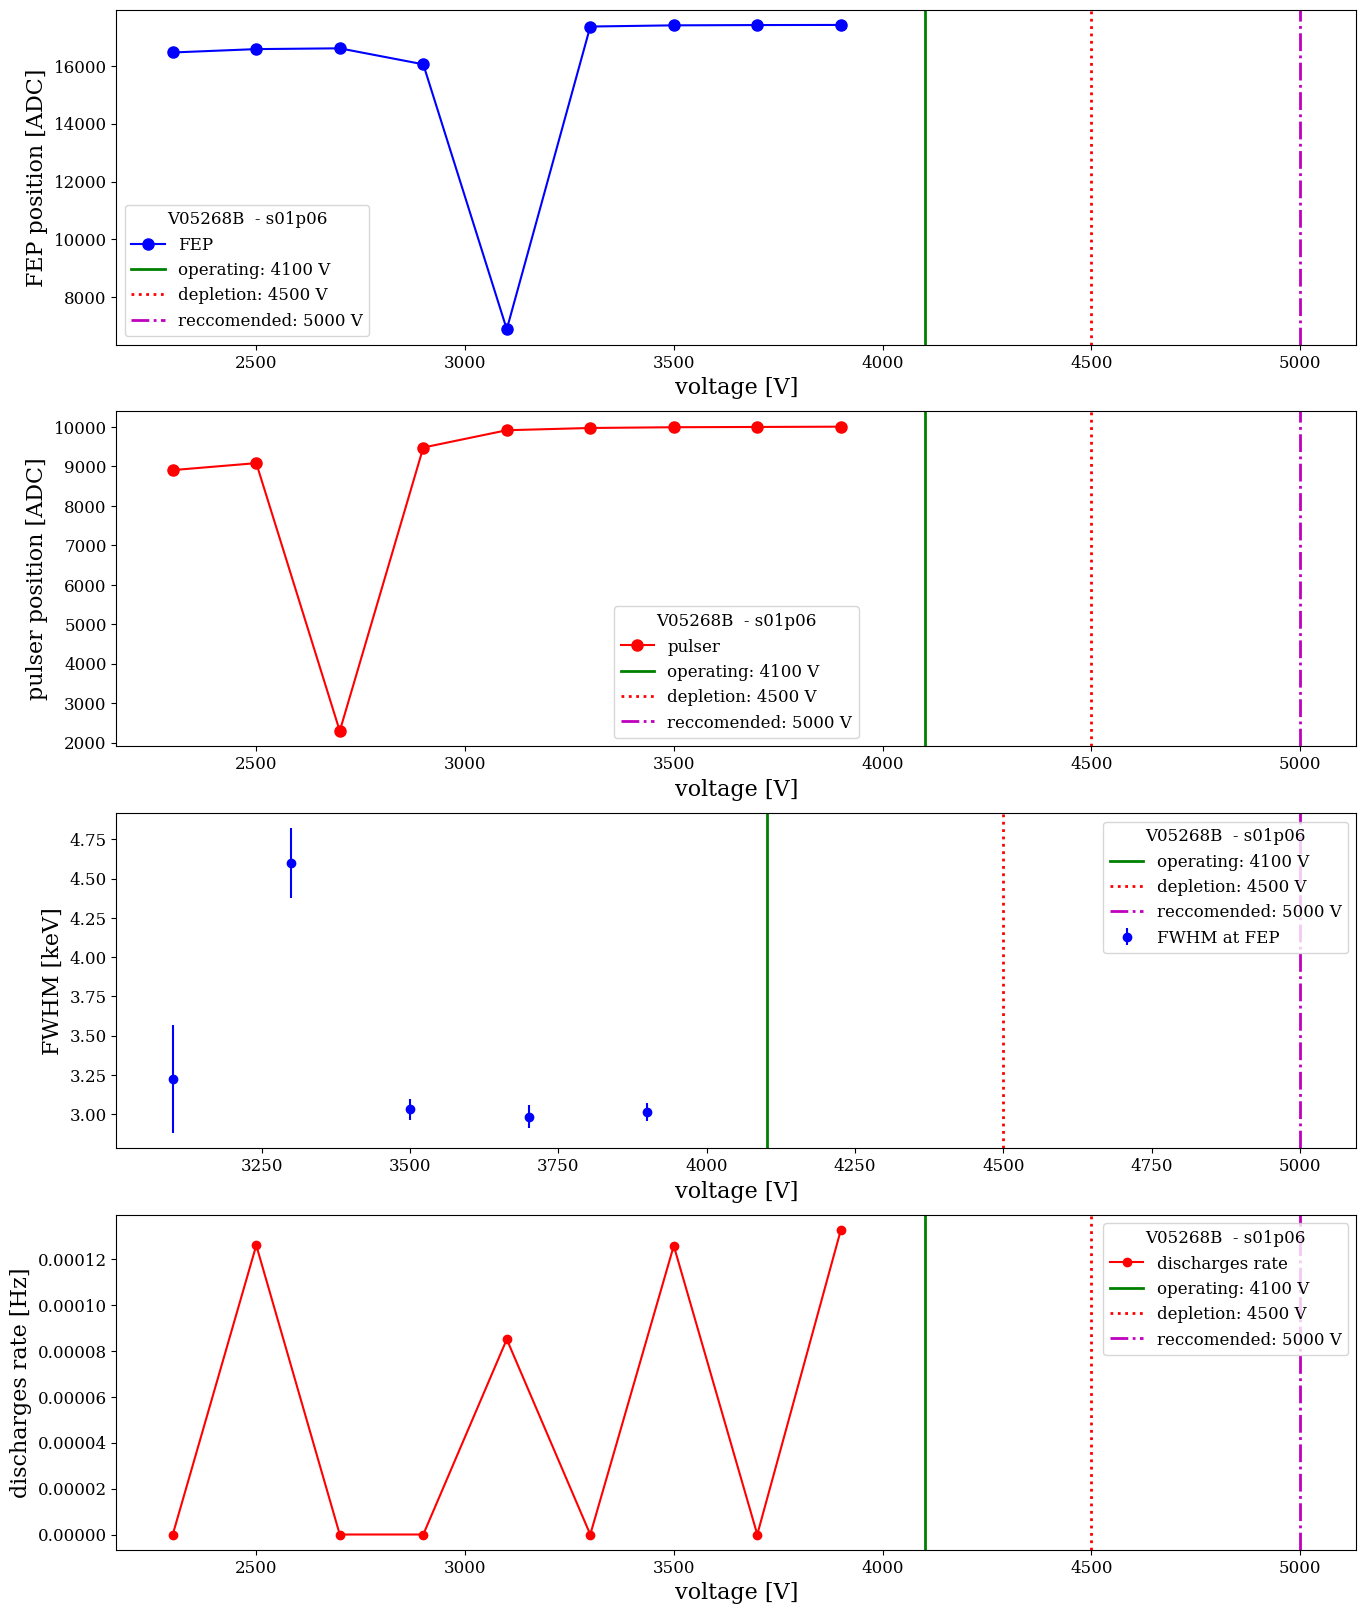

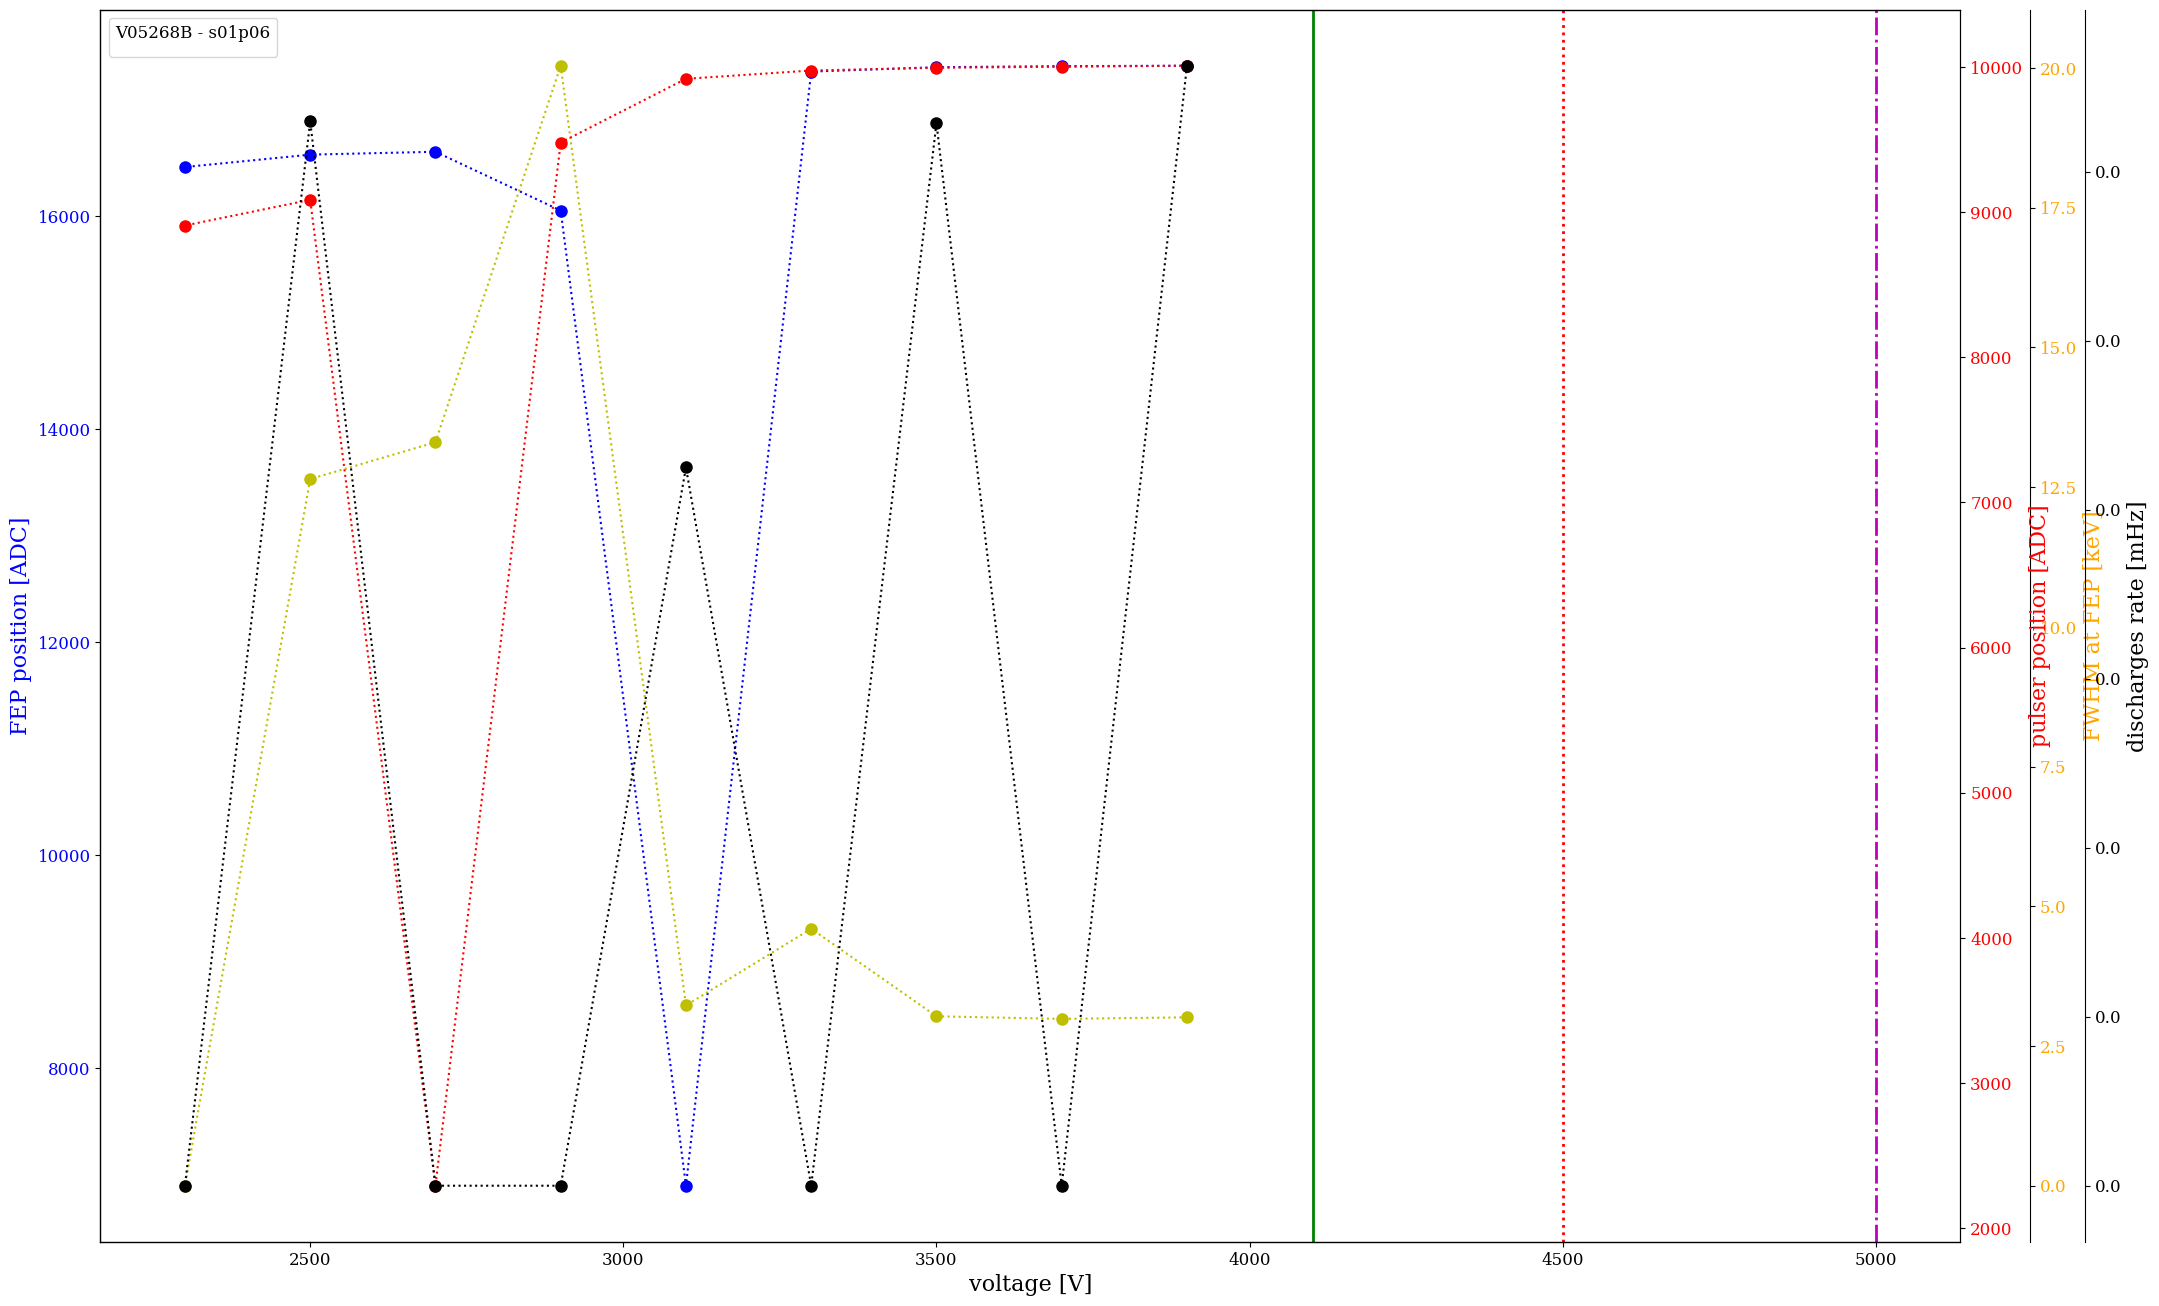

In [25]:
fig, axis = plt.subplots(nrows=4,figsize=(16,20), facecolor='white')

operating = float(test_dict[detectors[n_det]]['operating'])
try:
    manufacturer_hv = True
    depletion = float(test_dict[detectors[n_det]]['depletion'])
    reccomended = float(test_dict[detectors[n_det]]['reccomended'])
except:
    manufacturer_hv = False
    pass

peak_pos_FEP =  np.array([peak_FEP[n_det][f][0] for f in range(len(peak_FEP[n_det]))])
peak_fwhm_FEP =  np.array([peak_FEP[n_det][f][1] for f in range(len(peak_FEP[n_det]))])
peak_fwhm_err_FEP =  np.array([peak_FEP[n_det][f][2] for f in range(len(peak_FEP[n_det]))])
pulser_pos_ = np.array(pulser_pos[n_det][:nint])
discharges_rate_ = np.array(discharges_rate[n_det][:nint])
voltages_ = np.array(voltages[n_det][:nint])

#voltages, peak_pos, puls_pos = np.array(voltages[0][:nint]), np.array(peak_pos[:nint]), np.array(puls_pos[:nint])
#peak_rate, puls_rate = np.array(peak_rate[:nint]), np.array(puls_rate[:nint])
#peak_fwhm, peak_fwhm_err = np.array(peak_fwhm[:nint]), np.array(peak_fwhm_err[:nint])

axis[0].plot(voltages_,peak_pos_FEP,c='b',marker='o',ms=8,label='FEP')
axis[0].axvline(operating+1,c='g',ls='-',lw=2,label=f'operating: {operating:.0f} V')
if manufacturer_hv:
    axis[0].axvline(depletion-1,c='r',ls=':',lw=2,label=f'depletion: {depletion:.0f} V')
    axis[0].axvline(reccomended,c='m',ls='-.',lw=2,label=f'reccomended: {reccomended:.0f} V')
axis[0].set_xlabel('voltage [V]')
axis[0].set_ylabel('FEP position [ADC]')
axis[0].legend(title=f'{detectors[n_det]}  - s{string:02}p{position:02}')

axis[1].plot(voltages_,pulser_pos_,c='r',marker='o',ms=8,label='pulser')
axis[1].axvline(operating+1,c='g',ls='-',lw=2,label=f'operating: {operating:.0f} V')
if manufacturer_hv:
    axis[1].axvline(depletion-1,c='r',ls=':',lw=2,label=f'depletion: {depletion:.0f} V')
    axis[1].axvline(reccomended,c='m',ls='-.',lw=2,label=f'reccomended: {reccomended:.0f} V')
axis[1].set_xlabel('voltage [V]')
axis[1].set_ylabel('pulser position [ADC]')
axis[1].legend(title=f'{detectors[n_det]}  - s{string:02}p{position:02}')

mask_fwm = (peak_fwhm_FEP>0) & (peak_fwhm_FEP<8)
axis[2].errorbar(voltages_[mask_fwm],peak_fwhm_FEP[mask_fwm],yerr=peak_fwhm_err_FEP[mask_fwm], fmt='o',c='b',label=r'FWHM at FEP')
axis[2].axvline(operating+1,c='g',ls='-',lw=2,label=f'operating: {operating:.0f} V')
if manufacturer_hv:
    axis[2].axvline(depletion-1,c='r',ls=':',lw=2,label=f'depletion: {depletion:.0f} V')
    axis[2].axvline(reccomended,c='m',ls='-.',lw=2,label=f'reccomended: {reccomended:.0f} V')
axis[2].set_xlabel('voltage [V]')
axis[2].set_ylabel('FWHM [keV]')
axis[2].legend(title=f'{detectors[n_det]}  - s{string:02}p{position:02}')

axis[3].plot(voltages_,discharges_rate_,marker='o',c='r',label='discharges rate')
axis[3].axvline(operating+1,c='g',ls='-',lw=2,label=f'operating: {operating:.0f} V')
if manufacturer_hv:
    axis[3].axvline(depletion-1,c='r',ls=':',lw=2,label=f'depletion: {depletion:.0f} V')
    axis[3].axvline(reccomended,c='m',ls='-.',lw=2,label=f'reccomended: {reccomended:.0f} V')
axis[3].set_xlabel('voltage [V]')
axis[3].set_ylabel('discharges rate [Hz]')
axis[3].legend(title=f'{detectors[n_det]}  - s{string:02}p{position:02}')


fig1, axis1 = plt.subplots(figsize=(24,16), facecolor='white')
ax_count=0
ax1 = axis1.twinx()
ax2 = axis1.twinx()
ax3 = axis1.twinx()

axis1.plot(voltages_,peak_pos_FEP,'b:',marker='o',ms=8) #,label='FEP position')
ax1.plot(voltages_,peak_fwhm_FEP,'y:',marker='o',ms=8,label='FWHM at FEP')
#axis1.plot(voltages_,peak_pos_FEP,c='orange',ls=':',marker='o',ms=8,label='FWHM at FEP')
#axis1.plot(voltages_,peak_pos_FEP,'k:',marker='o',ms=8, label='discharges rate')
#ax1.plot(voltages_,peak_fwhm_FEP,c='orange',ls=':',marker='o',ms=8, label='FWHM at FEP')
ax2.plot(voltages_,pulser_pos_,'r:',marker='o',ms=8,label='pulser position')
ax3.plot(voltages_,discharges_rate_,'k:',marker='o',ms=8,label='discharges rate')
axis1.set_xlabel('voltage [V]')


axis1.set_ylabel('FEP position [ADC]',color='b')
axis1.tick_params(axis="y", labelcolor='b')
axis1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
axis1.legend(title=f'{detectors[n_det]} - s{string:02}p{position:02}',loc='upper left')
#pylim1, pylim2 = set_limits(peak_pos,shift=20)
#ax1.set_ylim(pylim1,pylim2

ax1.set_ylabel('FWHM at FEP [keV]',color='orange')
ax1.tick_params(axis="y", labelcolor='orange')
ax1.spines['right'].set_position(('outward', 50))
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
#fylim1, fylim2 = set_limits(peak_fwhm,shift=0.7)
#ax3.set_ylim(fylim1,fylim2)

ax2.set_ylabel('pulser position [ADC]',color='r')
ax2.tick_params(axis="y", labelcolor='r')
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
#ppylim1, ppylim2 = set_limits(puls_pos,shift=10)
#ax2.set_ylim(ppylim1,ppylim2)

ax3.set_ylabel('discharges rate [mHz]')
ax3.spines['right'].set_position(('outward', 90))
ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
#prlim1, prlim2 = set_limits(peak_rate,shift=0.1)
#ax5.set_ylim(prlim1,prlim2)

axis1.axvline(depletion,c='r',ls=':',lw=2,label=f'depletion: {depletion:.0f} V')
axis1.axvline(reccomended,c='m',ls='-.',lw=2,label=f'reccomended: {reccomended:.0f} V')
axis1.axvline(operating+1,c='g',ls='-',lw=2,label=f'operating: {operating:.0f} V')

#test_dict_chn = f'l200-{period}/{run}/results/l200-{period}-{run}-hv_scan_{ge_key}.json'
#with open(test_dict_chn, 'w') as file:
#    json.dump(test_dict[ge_key], file, indent=4)



In [26]:
hv_dict = {}
#hv_dict["peak_pos"] = list(peak_pos_FEP)
hv_dict["voltages"] = list(voltages_)
hv_dict["peak_fwhm"] = list(peak_fwhm_FEP)
hv_dict["puls_pos"] = list(pulser_pos_)
hv_dict["rate_discharges"] = list(discharges_rate_)
print(list(peak_pos_FEP))
file_path_new = '/lfs/l1/legend/users/bianca/PSD_HVscan/results/'
with open(f'{file_path_new}/{detectors[n_det]}_new.json','w') as new_file:
    json.dump(hv_dict, new_file, indent=4)

[17410.33, 17406.33, 17396.33, 17355.25, 6897.3276, 16050.6045, 16602.727, 16575.646, 16459.406]


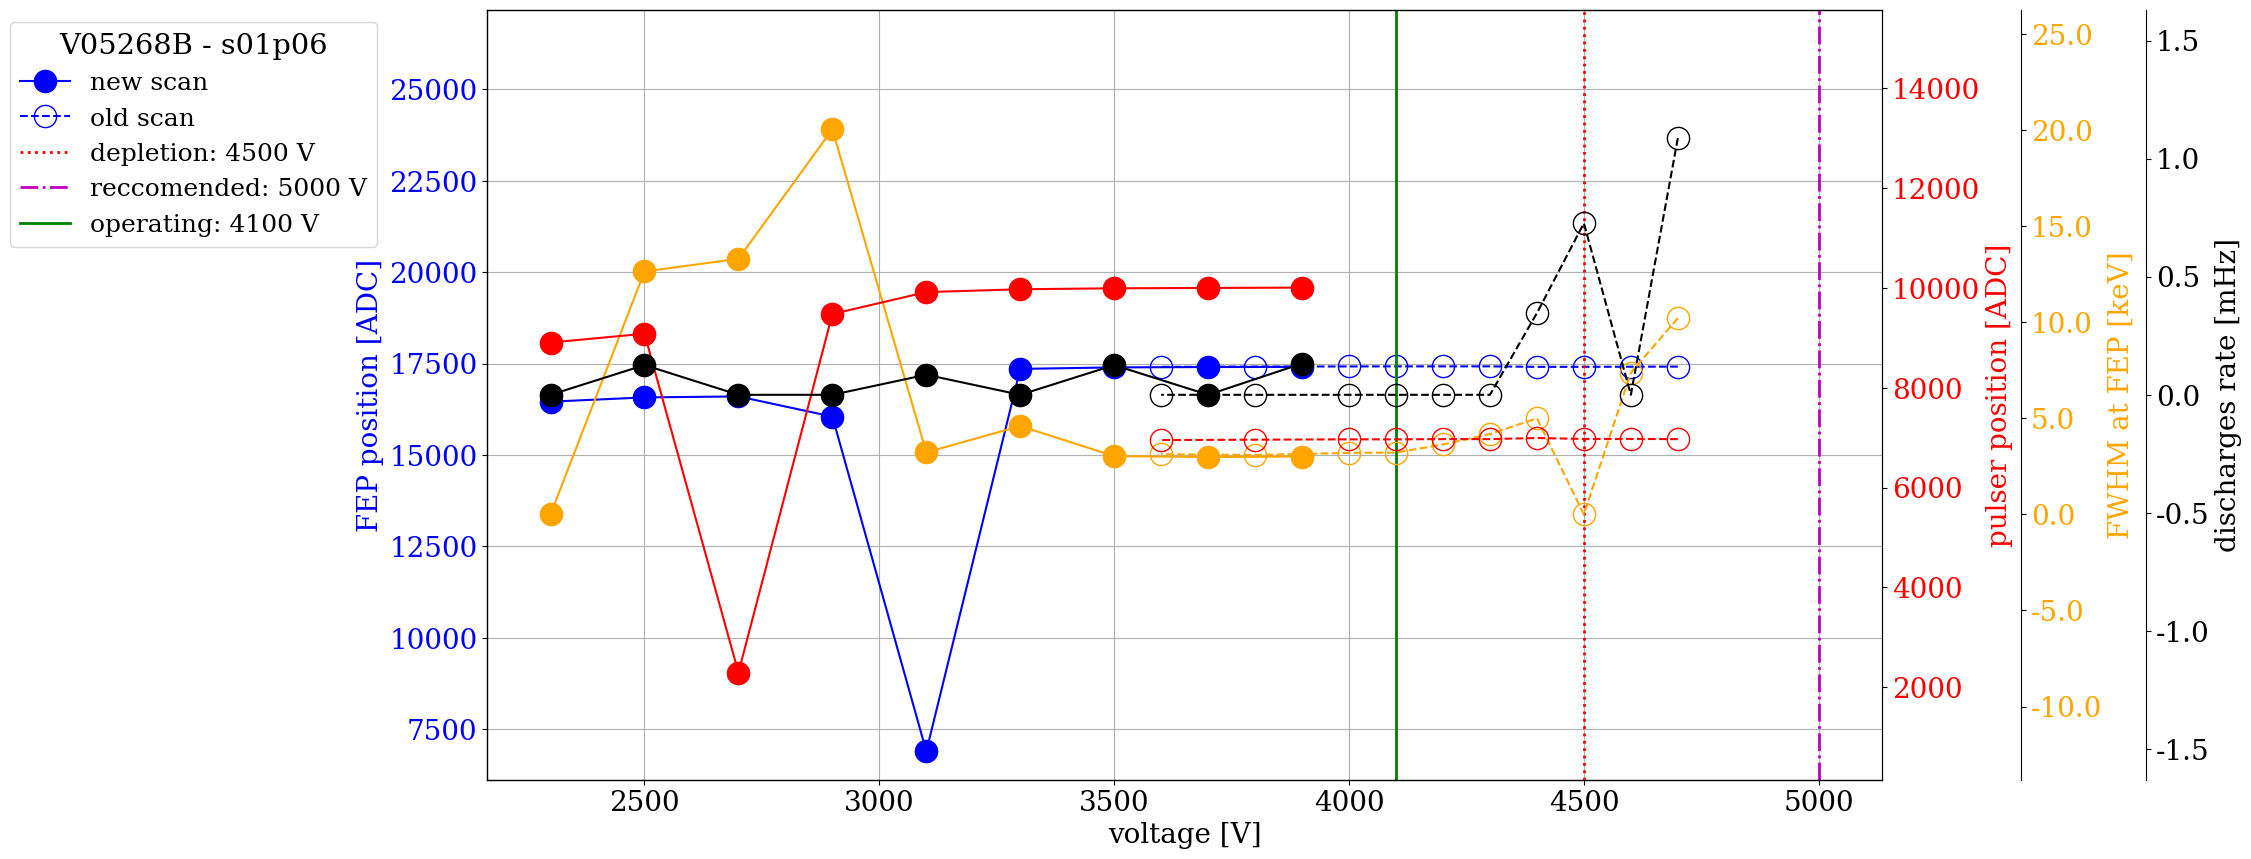

In [27]:
plt.rcParams['legend.title_fontsize'] = 'xx-large'
#['V05261B', 'V05266A', 'V05266B', 'V05268B', 'V05612A', 'V05267B', 'V05261A', 'V05268A', 'V05267A', 'V05612B']
#V05267B
#detectors = ['V05268B']
#n_volt = ge_keys.index('V05268B')
n_det = 0
string = int(chmap[detectors[n_det]]['location']['string'])
position = int(chmap[detectors[n_det]]['location']['position'])
operating = float(test_dict[detectors[n_det]]['operating'])
try:
    manufacturer_hv = True
    depletion = float(test_dict[detectors[n_det]]['depletion'])
    reccomended = float(test_dict[detectors[n_det]]['reccomended'])
except:
    manufacturer_hv = False
    pass
'''
#new scan
file_path_new = '/lfs/l1/legend/users/bianca/PSD_HVscan/results/'
with open(f'{file_path_new}/{detectors[n_det]}.json','r') as new_file:
    scan_new = json.load(new_file)
voltages_ = np.array([int(v) for v in scan_new['voltages']]) 
peak_pos_FEP = np.array([float(v) for v in scan_new['peak_pos']]) 
peak_fwhm_FEP = np.array([float(v) for v in scan_new['peak_fwhm']]) 
pulser_pos_ = np.array([float(v) for v in scan_new['puls_pos']]) 
discharges_rate_ = np.array([float(v) for v in scan_new['rate_discharges']]) 
'''

#comparison with old scan
file_path ='/lfs/l1/legend/users/dandrea/legend-ge-processing/l200-p05/r005/results'
with open(f'{file_path}/l200-p05-r005-hv_scan_{detectors[n_det]}.json', "r") as outfile: 
    scan_old = json.load(outfile)

voltages_old = np.array([int(v) for v in scan_old['voltages']]) 
peak_pos_FEP_old = np.array([float(v) for v in scan_old['peak_pos']]) 
peak_fwhm_FEP_old = np.array([float(v) for v in scan_old['peak_fwhm']]) 
pulser_pos_old = np.array([float(v) for v in scan_old['puls_pos']]) 
discharges_rate_old = np.array([float(v) for v in scan_old['rate_discharges']]) 


fig1, axis1 = plt.subplots(figsize=(18,10), facecolor='white')
axis1.grid()
ax1 = axis1.twinx()
ax2 = axis1.twinx()
ax3 = axis1.twinx()

mask_peak = (peak_fwhm_FEP<100) #(peak_pos_FEP>0)#15500)
mask_peak_old = (peak_fwhm_FEP_old<100) #(peak_pos_FEP_old>0)#15500)
axis1.plot(voltages_[mask_peak],peak_pos_FEP[mask_peak],'b:',marker='o',ms=16,ls='-', label='new scan')
axis1.plot(voltages_old[mask_peak_old],peak_pos_FEP_old[mask_peak_old],'b:',marker='o',ms=16, ls='--',markerfacecolor='none', label='old scan')

ax1.plot(voltages_[mask_peak],np.array(peak_fwhm_FEP)[mask_peak],color='orange',marker='o',ms=16,ls='-')
ax1.plot(voltages_old[mask_peak_old],peak_fwhm_FEP_old[mask_peak_old],color='orange',marker='o',ms=16, ls='--',markerfacecolor='none') 

ax2.plot(voltages_,pulser_pos_,'r:',marker='o',ms=16,ls='-')
ax2.plot(voltages_old,pulser_pos_old,'r:',marker='o',ms=16, ls='--',markerfacecolor='none') 

ax3.plot(voltages_,discharges_rate_*1000,'k:',marker='o',ms=16,ls='-')
ax3.plot(voltages_old,discharges_rate_old*1000,'k:',marker='o',ms=16,ls='--',markerfacecolor='none') 

axis1.set_xlabel('voltage [V]', fontsize=20)
axis1.tick_params(labelsize=20)

axis1.set_ylabel('FEP position [ADC]',color='b', fontsize="20")
axis1.tick_params(axis="y", labelcolor='b', labelsize=20)
axis1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
peak_pos_tot = list(peak_pos_FEP[mask_peak])+ list(peak_pos_FEP_old[mask_peak_old]) 
x_arr=[(np.min(peak_pos_tot),np.max(peak_pos_tot))]
shift=np.std(x_arr)*2
pylim1, pylim2 = set_limits(np.array(peak_pos_tot),shift=shift)
axis1.set_ylim(pylim1,pylim2)

ax1.set_ylabel('FWHM at FEP [keV]',color='orange', fontsize="20")
ax1.tick_params(axis="y", labelcolor='orange', labelsize=20)
ax1.spines['right'].set_position(('outward', 100))
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
peak_fwhm_tot = list(np.array(peak_fwhm_FEP)[mask_peak])+list(peak_fwhm_FEP_old[mask_peak_old])
x_arr=[(np.min(peak_fwhm_tot),np.max(peak_fwhm_tot))]
shift=np.std(x_arr)*2
fylim1, fylim2 = set_limits(np.array(peak_fwhm_tot),shift=shift)
ax1.set_ylim(fylim1,fylim2)


ax2.set_ylabel('pulser position [ADC]',color='r', fontsize="20")
ax2.tick_params(axis="y", labelcolor='r', labelsize=20)
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
pulser_pos_tot = list(pulser_pos_)+list(pulser_pos_old)
x_arr=[(np.min(pulser_pos_tot),np.max(pulser_pos_tot))]
shift=np.std(x_arr)*2
ppylim1, ppylim2 = set_limits(np.array(pulser_pos_tot),shift=shift)
ax2.set_ylim(ppylim1,ppylim2)


ax3.set_ylabel('discharges rate [mHz]', fontsize="20")
ax3.tick_params(axis="y", labelsize=20)
ax3.spines['right'].set_position(('outward', 190))
ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
discharges_rate_tot = list(discharges_rate_)+list(discharges_rate_old)
x_arr=[(np.min(discharges_rate_tot),np.max(discharges_rate_tot))]
shift=np.std(x_arr)*3
prlim1, prlim2 = set_limits(np.array(discharges_rate_tot),shift=shift*1000)
ax3.set_ylim(prlim1,prlim2)

axis1.axvline(depletion,c='r',ls=':',lw=2,label=f'depletion: {depletion:.0f} V')
axis1.axvline(reccomended,c='m',ls='-.',lw=2,label=f'reccomended: {reccomended:.0f} V')
axis1.axvline(operating+1,c='g',ls='-',lw=2,label=f'operating: {operating:.0f} V')
axis1.legend(title=f'{detectors[n_det]} - s{string:02}p{position:02}',bbox_to_anchor=(-0.07, 1.0), fontsize="18")

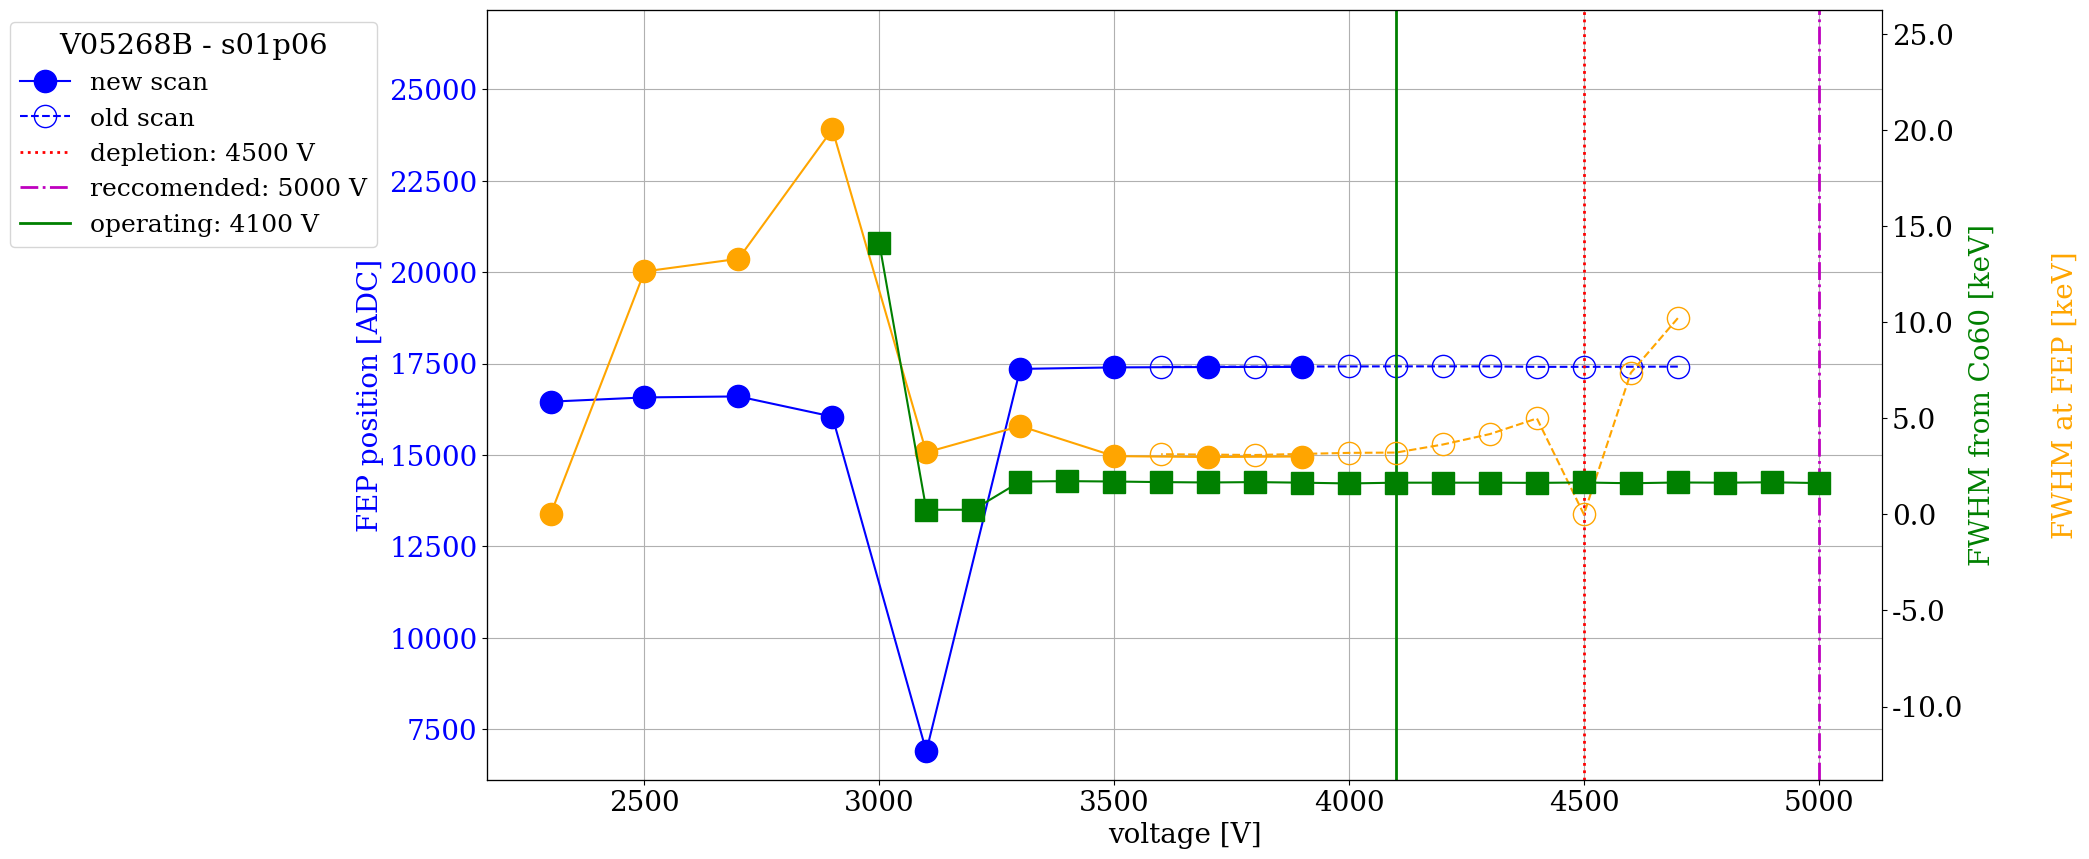

In [28]:
import csv

#comparison with old scan
file_path ='/lfs/l1/legend/users/dandrea/legend-ge-processing/l200-p05/r005/results'
with open(f'{file_path}/l200-p05-r005-hv_scan_{detectors[n_det]}.json', "r") as outfile: 
    scan_old = json.load(outfile)
    
voltages_old = np.array([int(v) for v in scan_old['voltages']]) 
peak_pos_FEP_old = np.array([float(v) for v in scan_old['peak_pos']]) 
peak_fwhm_FEP_old = np.array([float(v) for v in scan_old['peak_fwhm']]) 
pulser_pos_old = np.array([float(v) for v in scan_old['puls_pos']]) 
discharges_rate_old = np.array([float(v) for v in scan_old['rate_discharges']]) 

#compare with Co60 HADES characterization
voltages_Co60 = []
peak_fwhm_Co60 = []

file_path_Co60 ='/lfs/l1/legend/users/redchuk/hades-char/V05_FWHM_vs_HV/'
with open(f'{file_path_Co60}/{detectors[n_det]}.csv', "r") as csv_file: 
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        voltages_Co60.append(int(row['opV']))
        peak_fwhm_Co60.append(float(row['fwhm_co60fep']))

fig1, axis1 = plt.subplots(figsize=(18,10), facecolor='white')
axis1.grid()
ax1 = axis1.twinx()
ax2 = axis1.twinx()
#ax3 = axis1.twinx()

mask_peak = (peak_fwhm_FEP<100) #(peak_pos_FEP>0)#15500)
mask_peak_old = (peak_fwhm_FEP_old<100) #(peak_pos_FEP_old>0)#15500)
axis1.plot(voltages_[mask_peak],peak_pos_FEP[mask_peak],'b:',marker='o',ms=16,ls='-', label='new scan')
axis1.plot(voltages_old[mask_peak_old],peak_pos_FEP_old[mask_peak_old],'b:',marker='o',ms=16, ls='--',markerfacecolor='none', label='old scan')

ax1.plot(voltages_[mask_peak],np.array(peak_fwhm_FEP)[mask_peak],color='orange',marker='o',ms=16,ls='-')
ax1.plot(voltages_old[mask_peak_old],peak_fwhm_FEP_old[mask_peak_old],color='orange',marker='o',ms=16, ls='--',markerfacecolor='none') 

ax2.plot(voltages_Co60,peak_fwhm_Co60,'g:',marker='s',ms=16,ls='-')

axis1.set_xlabel('voltage [V]', fontsize=20)
axis1.tick_params(labelsize=20)

axis1.set_ylabel('FEP position [ADC]',color='b', fontsize="20")
axis1.tick_params(axis="y", labelcolor='b', labelsize=20)
axis1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
peak_pos_tot = list(peak_pos_FEP[mask_peak])+ list(peak_pos_FEP_old[mask_peak_old])
x_arr=[(np.min(peak_pos_tot),np.max(peak_pos_tot))]
shift=np.std(x_arr)*2
pylim1, pylim2 = set_limits(np.array(peak_pos_tot),shift=shift)
axis1.set_ylim(pylim1,pylim2)

ax1.set_ylabel('FWHM at FEP [keV]',color='orange', fontsize="20")
ax1.tick_params(axis="y", colors='white', labelcolor='white', labelsize=20)
ax1.spines['right'].set_position(('outward', 60))
ax1.spines['right'].set_color('white')
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
peak_fwhm_tot = list(np.array(peak_fwhm_FEP)[mask_peak])+list(peak_fwhm_FEP_old[mask_peak_old])
x_arr=[(np.min(peak_fwhm_tot),np.max(peak_fwhm_tot))]
shift=np.std(x_arr)*2
fylim1, fylim2 = set_limits(np.array(peak_fwhm_tot),shift=shift)



ax2.set_ylabel('FWHM from Co60 [keV]',color='g', fontsize="20")
ax2.tick_params(axis="y", labelcolor='black', labelsize=20)
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
x_arr=[(np.min(peak_fwhm_Co60),np.max(peak_fwhm_Co60))]
shift=np.std(x_arr)*2
ppylim1, ppylim2 = set_limits(np.array(peak_fwhm_Co60),shift=shift)
fmin=min(fylim1,ppylim1)
fmax=max(fylim2,ppylim2)
ax2.set_ylim(fmin,fmax)
ax1.set_ylim(fmin,fmax)



axis1.axvline(depletion,c='r',ls=':',lw=2,label=f'depletion: {depletion:.0f} V')
axis1.axvline(reccomended,c='m',ls='-.',lw=2,label=f'reccomended: {reccomended:.0f} V')
axis1.axvline(operating+1,c='g',ls='-',lw=2,label=f'operating: {operating:.0f} V')
axis1.legend(title=f'{detectors[n_det]} - s{string:02}p{position:02}',bbox_to_anchor=(-0.07, 1.0), fontsize="18")

In [101]:
peak_pos_FEP = np.array([peak_FEP[n_det][f][0] for f in range(len(peak_FEP[n_det]))])
peak_fwhm_FEP=[peak_FEP[n_det][f][1] for f in range(len(peak_FEP[n_det]))]
peak_fwhm_err_FEP=[peak_FEP[n_det][f][2] for f in range(len(peak_FEP[n_det]))]
pulser_pos_ = np.array(pulser_pos[n_det][:nint])
discharges_rate_ = np.array(discharges_rate[n_det][:nint])
voltages_ = np.array(voltages[n_det][:])
print('peak_pos:', peak_pos_FEP)
print('peak_FWHM:', peak_fwhm_FEP)
print('peak_FWHM_err:', peak_fwhm_err_FEP)
print('pulser_pos:', pulser_pos_)
print('discharges_rate:', discharges_rate_old)
print(voltages_)


peak_pos: [16003.524  15998.524  15999.524  15994.444  15976.444  15977.444
  4175.438   2551.59   15021.5205 15231.001 ]
peak_FWHM: [2.9548007224918176, 2.9996411242611924, 3.1113854218843726, 3.0300910034099027, 3.3433305227042456, 3.1212968391262987, 55.01314699686634, 23.832284659713512, 20.78616193443836, 13.344200807822801]
peak_FWHM_err: [0.05952759493964629, 0.059546823135924035, 0.06518500951978148, 0.07179342968901592, 0.08248396826264043, 0.1463382486874487, 3.357871905871366, 1.9022928537910098, 0.00034778165303035356, 0.2625657123524164]
pulser_pos: [10452.5 10455.5 10460.5 10467.5 10477.5 10487.5 10511.5 10540.5 11374.5
 11743.5]
discharges_rate: [0.00036221 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[3500. 3400. 3300. 3200. 3100. 3000. 2900. 2800. 2600. 2400.]


## Depletion Voltage

## Energy spectrum

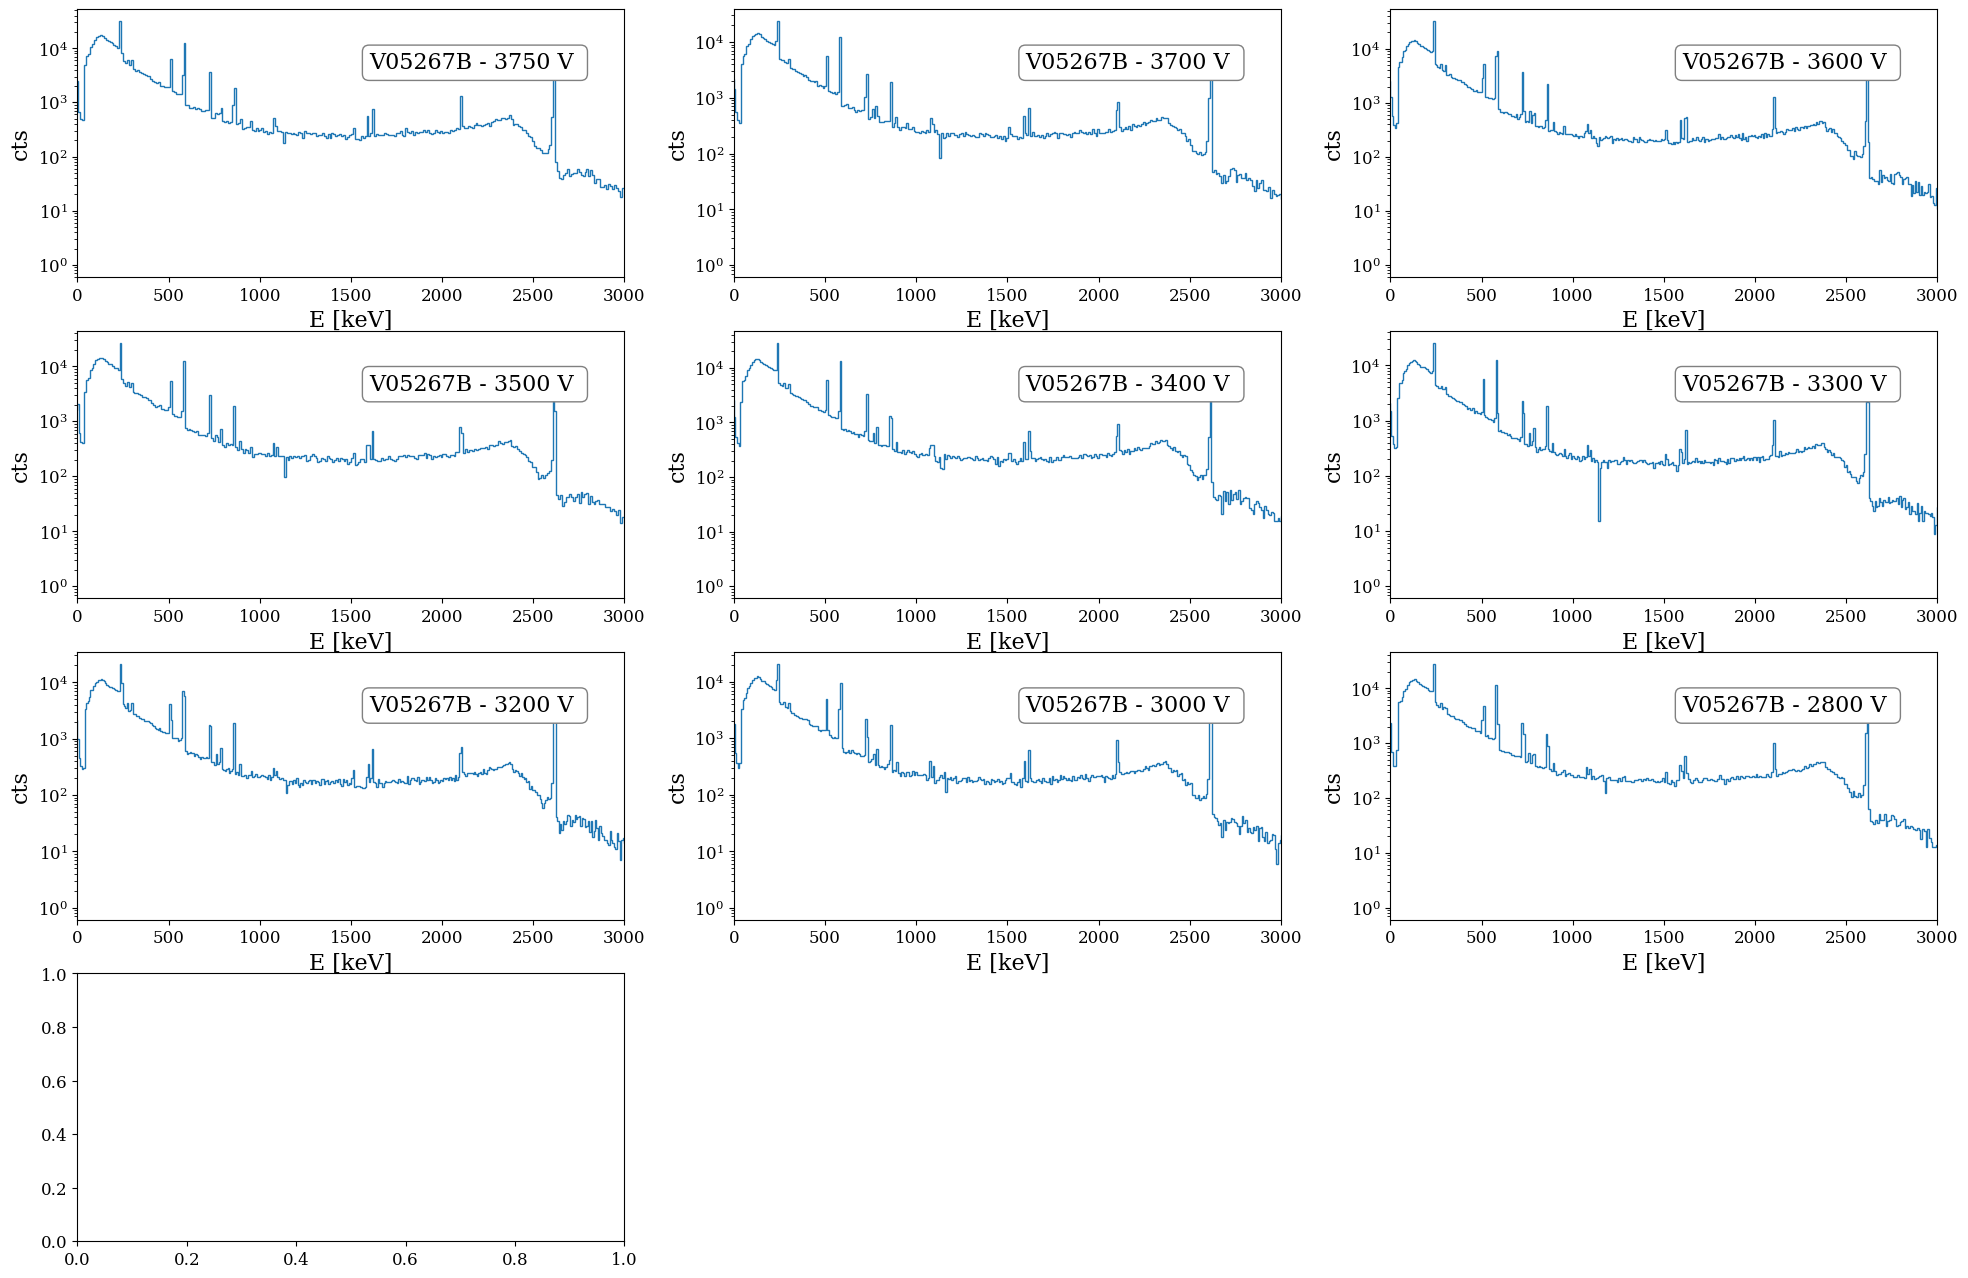

In [33]:
fig, axis = plt.subplots(nrows=4, ncols=3, figsize=(24,16), facecolor='white')
axis[3][1].axis('off')
axis[3][2].axis('off')

nscan = 0
for energies_scan,  voltages_scan in zip(energies[n_det], voltages[n_det]):
    ax = axis.flat[nscan]
    ax.hist(energies_scan, bins=500, histtype="step")
    ax.set_yscale("log")
    ax.set_xlabel('E [keV]')
    ax.set_ylabel('cts')
    ax.set_xlim((0,3000))
    ax.annotate(f'{detectors[n_det]} - {voltages_scan:.0f} V ', xy=(210, 150), xycoords='axes points',
            size=16, bbox=dict(boxstyle='round', fc='w',  edgecolor='grey') )   
    nscan+=1
    
if save_fig == True:
    savefig(fig, detectors[n_det], "energy_spectrum")

## A spectrum

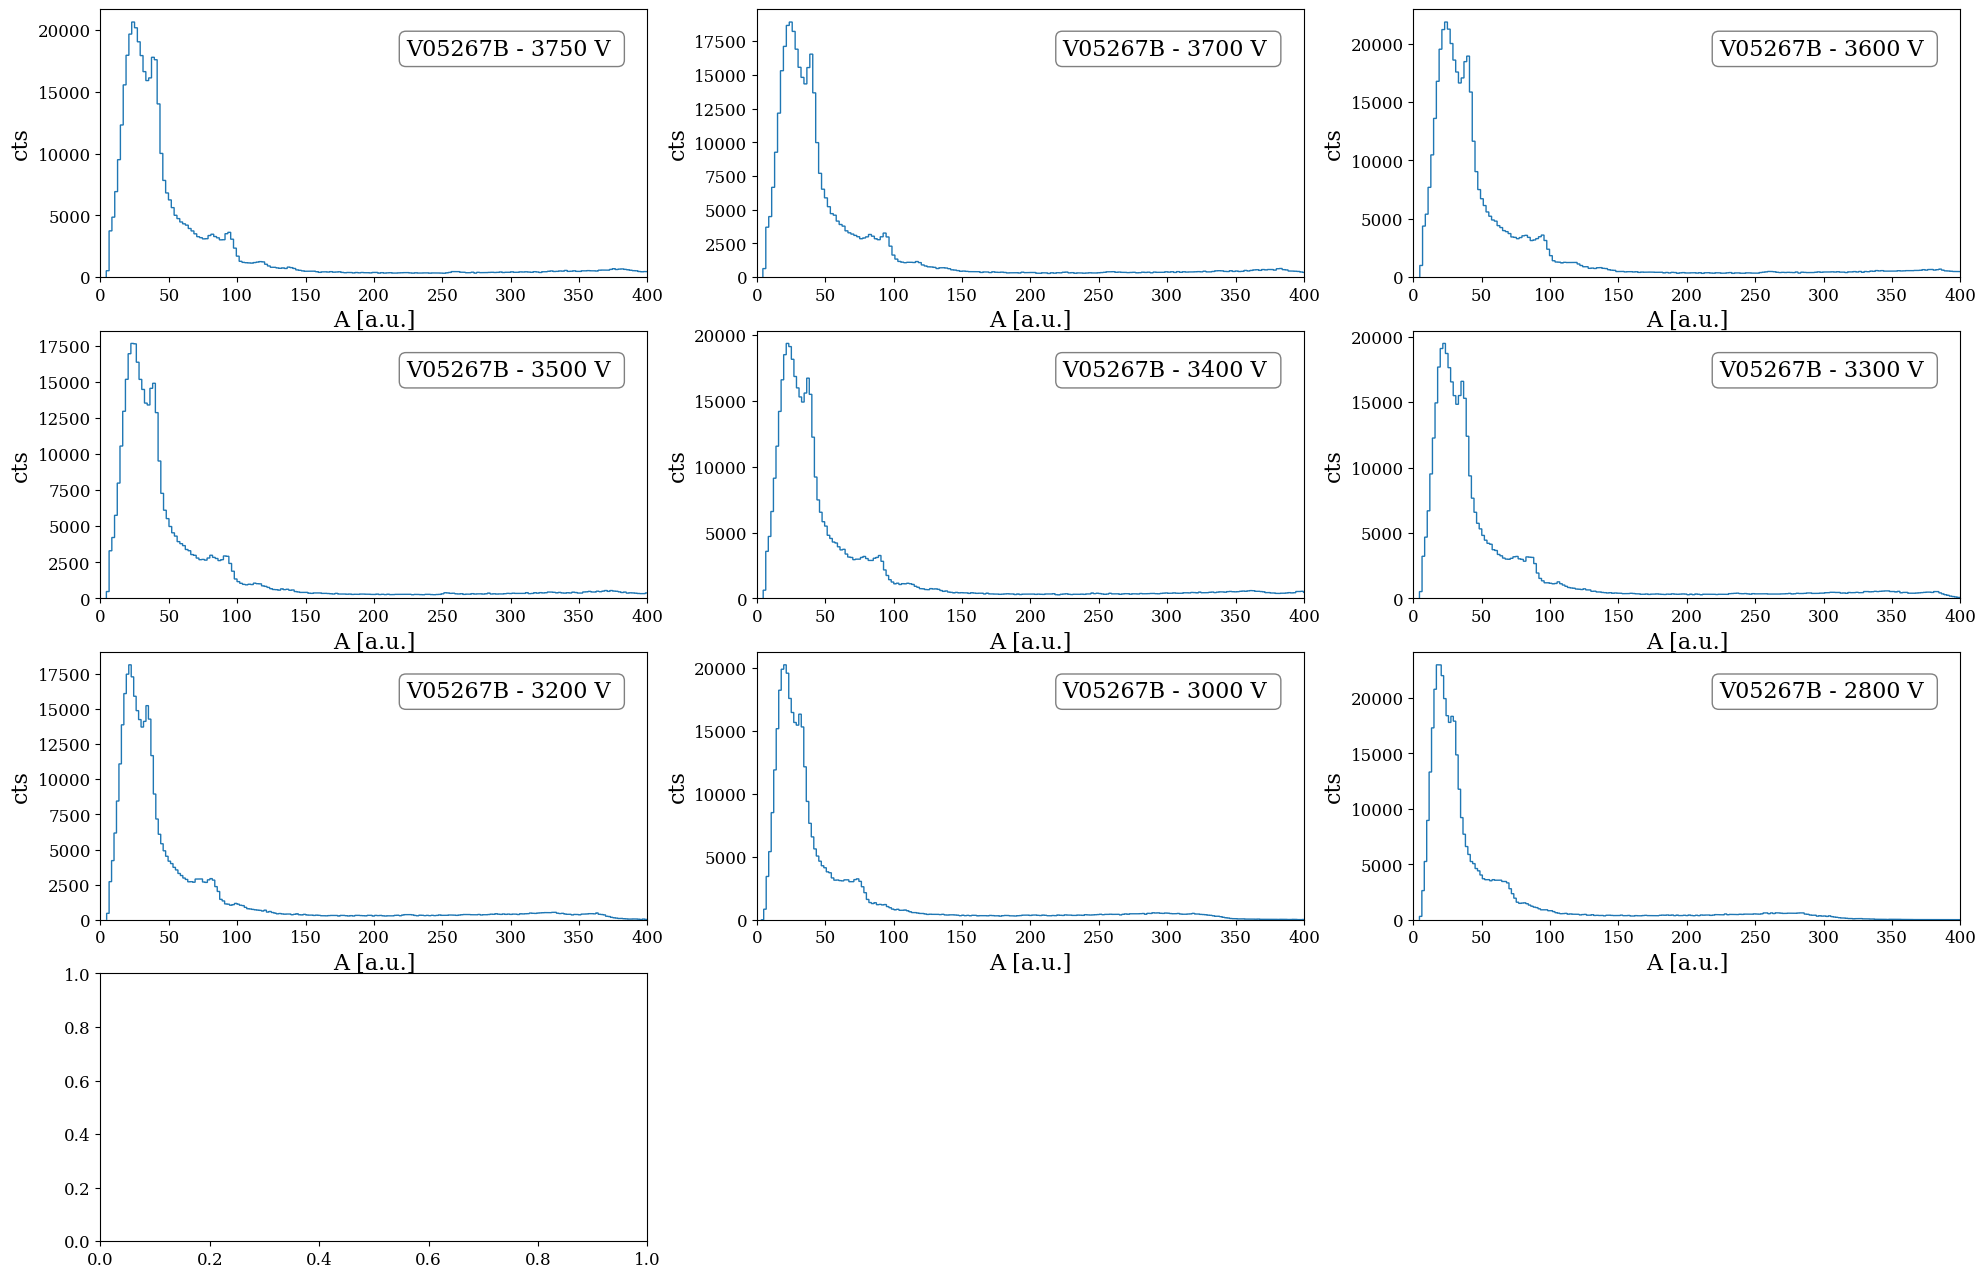

In [64]:
fig, axis = plt.subplots(nrows=4, ncols=3, figsize=(24,16), facecolor='white')
axis[3][1].axis('off')
axis[3][2].axis('off')

nscan = 0
for a_max_scan,  voltages_scan in zip(a_max[n_det], voltages[n_det]):
    ax = axis.flat[nscan]
    ax.hist(a_max_scan, bins=1000, histtype="step")
    ax.set_xlabel('A [a.u.]')
    ax.set_ylabel('cts')
    ax.set_xlim((0,400))
    ax.annotate(f'{detectors[n_det]} - {voltages_scan:.0f} V ', xy=(220, 160), xycoords='axes points',
            size=16, bbox=dict(boxstyle='round', fc='w',  edgecolor='grey') )        
    nscan+=1

if save_fig == True:
    savefig(fig, detectors[n_det], "A_spectrum")

## A/E vs E

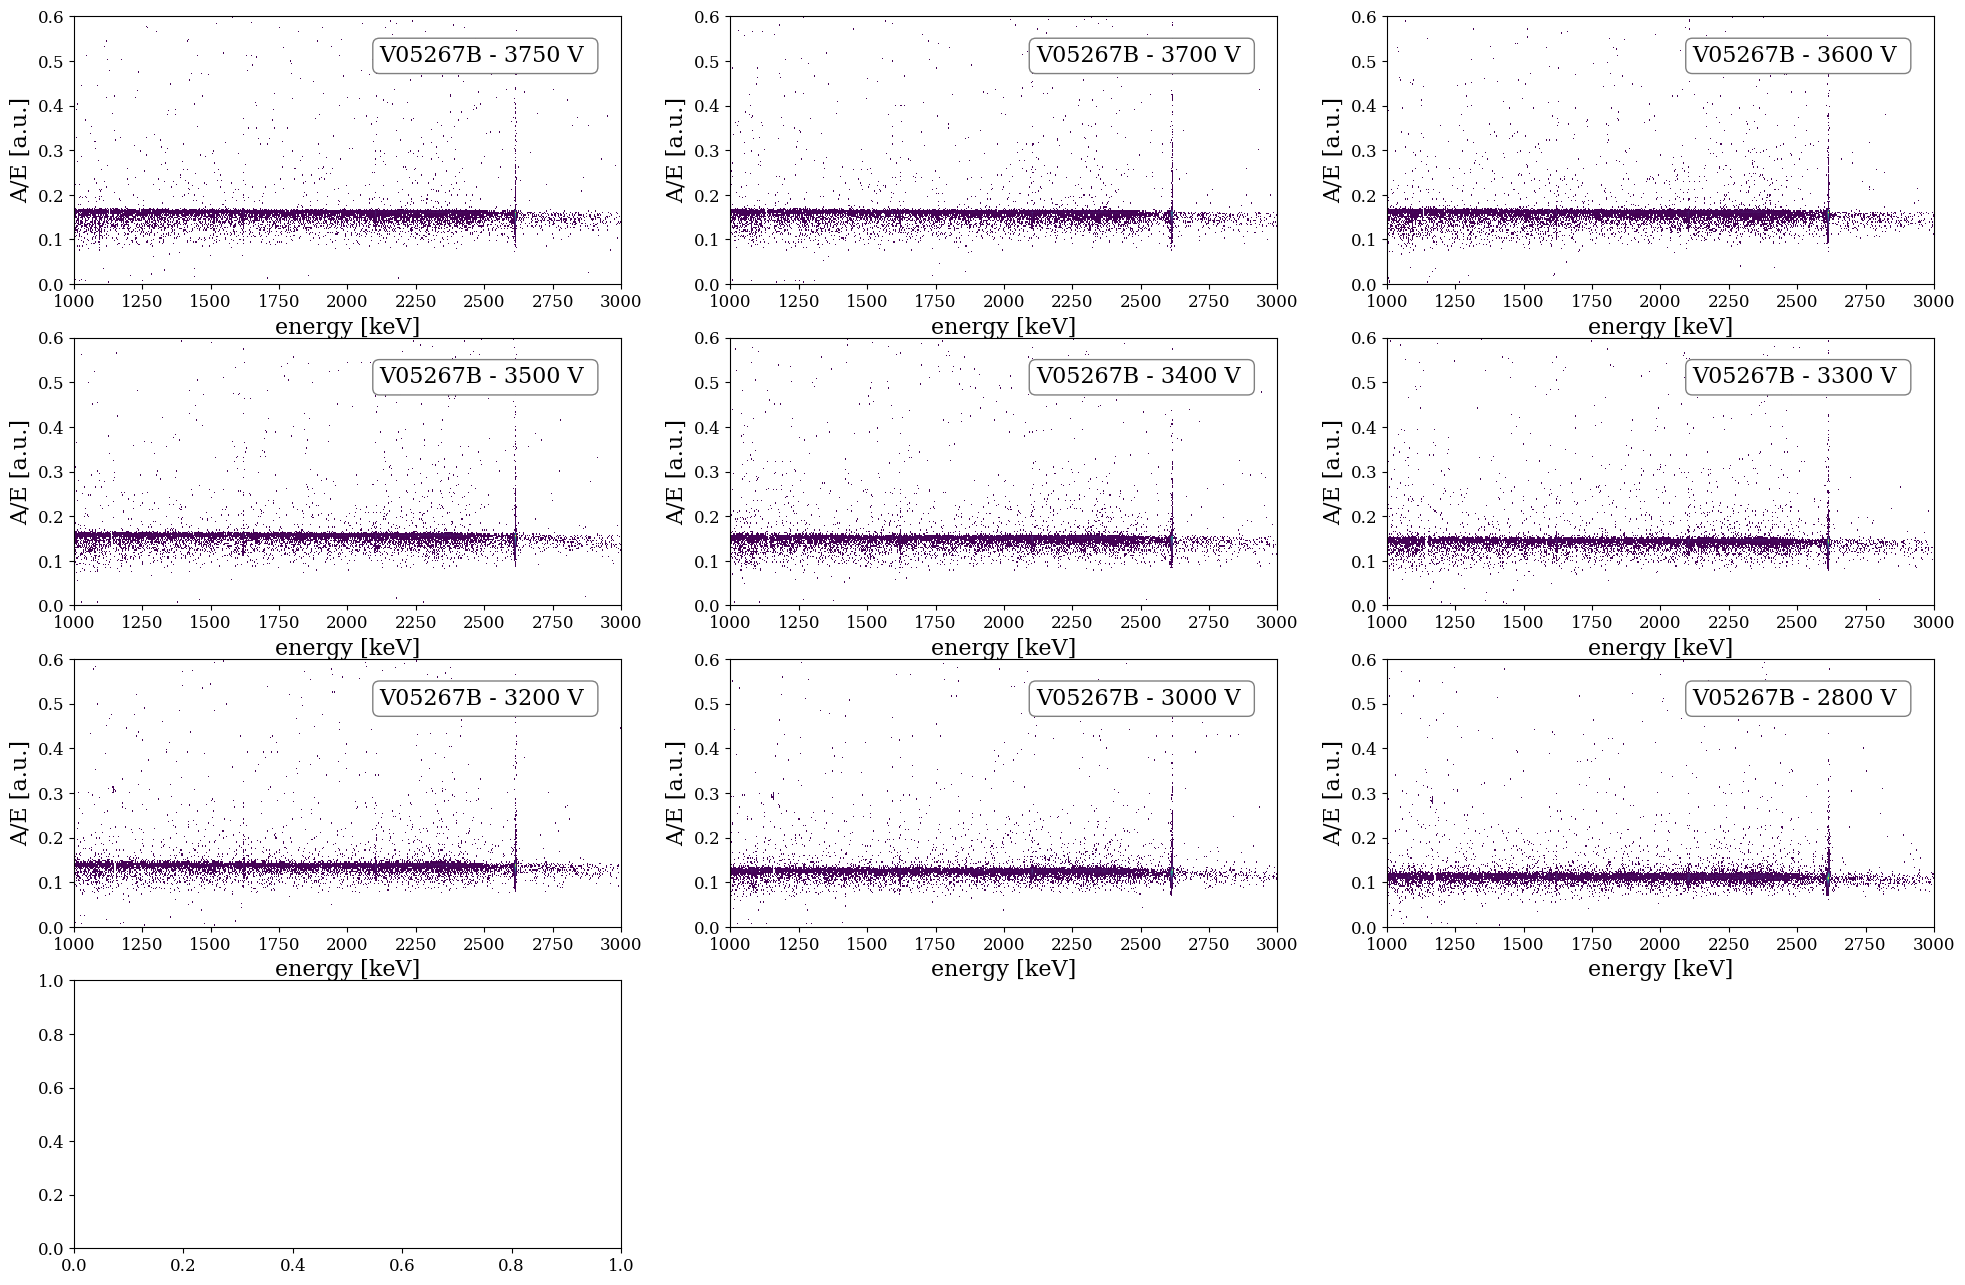

In [65]:
fig, axis = plt.subplots(nrows=4, ncols=3, figsize=(24,16), facecolor='white')
axis[3][1].axis('off')
axis[3][2].axis('off')

nscan = 0
for a_max_scan, energies_scan, voltages_scan in zip(a_max[n_det], energies[n_det], voltages[n_det]):
    ax = axis.flat[nscan]
    aoe = a_max_scan/energies_scan
    cut = (energies_scan>1000) & (aoe< 2)
    ax.hist2d(energies_scan[cut], aoe[cut], bins=(2000,200), range=([1000,3000],[0.0,0.6]), cmin = 1)
    ax.set_xlabel('energy [keV]')
    ax.set_ylabel('A/E [a.u.]')
    ax.set_xlim((1000,3000))     
    ax.annotate(f'{detectors[n_det]} - {voltages_scan:.0f} V ', xy=(220, 160), xycoords='axes points',
        size=16, bbox=dict(boxstyle='round', fc='w',  edgecolor='grey') )
    nscan+=1
    
if save_fig == True:
    savefig(fig, detectors[n_det], "AoE_vs_E")

## Drift time vs A/E

#### Which A/E fit function?

In [66]:
#pdf with or without tail
pdf_fit = aoe_cal.standard_aoe_with_high_tail #aoe_cal.standard_aoe

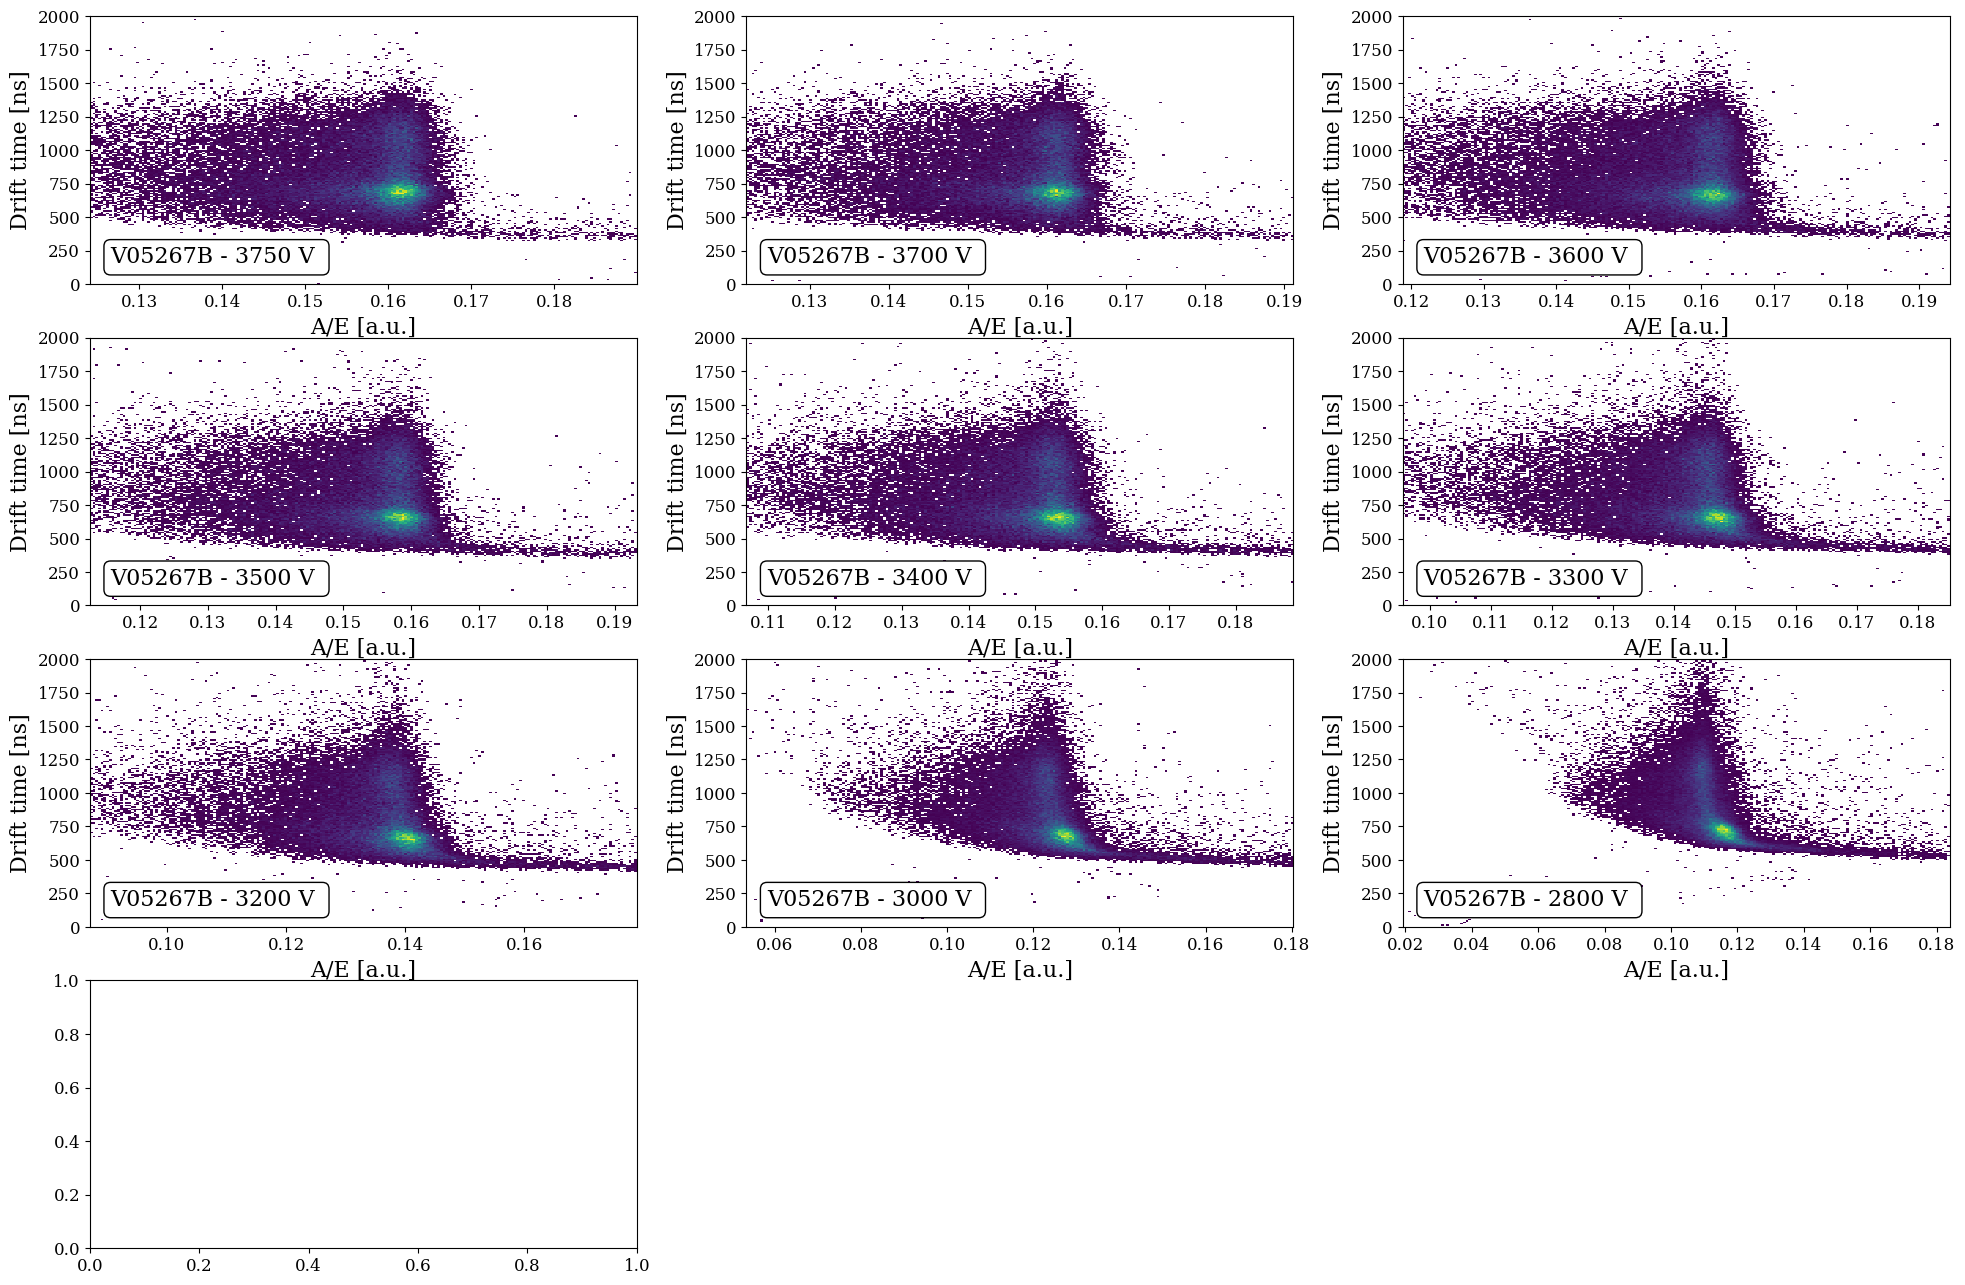

In [67]:
fig, axis = plt.subplots(nrows=4, ncols=3, figsize=(24,16), facecolor='white')
axis[3][1].axis('off')
axis[3][2].axis('off')

if detector_type == "PPC":
    dt_max=1000
elif detector_type != "PPC" and detectors[n_det]!="V05268B":
    dt_max=2000
else:
    dt_max=2000

nscan = 0
for a_max_scan, energies_scan, dt_eff_scan, voltages_scan in zip(a_max[n_det],energies[n_det],dt_eff[n_det], voltages[n_det]):
    cuts_titles = ['>1MeV']#,'DEP', 'DEP']
    cuts = [(energies_scan>1000)] #, ( (energies_scan>1000) & (energies_scan<1400) ),( (energies_scan>1700) & (energies_scan<2100))]
    for idx, cut in enumerate(cuts):
        ax = axis.flat[nscan]
        aoe = a_max_scan/energies_scan
        dt_eff_cut=dt_eff_scan[(cut) & (aoe<1000)]     
        aoe = aoe[(cut) & (aoe<1000)] 
        par, err, migrad, _ = aoe_cal.unbinned_aoe_fit(aoe, pdf=pdf_fit, display=0)
        mu = par[1]
        sigma = par[2]
        fmin = mu - 20 * sigma
        fmax = mu + 15 * sigma
        if fmin<0:
            fmin=0.1
            fmax=0.45
        ax.hist2d(aoe, dt_eff_cut, bins=(200,200), range=((fmin,fmax),(0,dt_max)), cmin=1)
        ax.set_ylabel('Drift time [ns]')
        ax.set_xlabel('A/E [a.u.]')
        ax.annotate(f'{detectors[n_det]} - {voltages_scan:.0f} V ', xy=(15, 15), xycoords='axes points',
            size=16, bbox=dict(boxstyle='round', fc='w') )   
    nscan+=1

if save_fig == True:
    savefig(fig, detectors[n_det], "drift-time_vs_AoE")

## A/E distribution study

#### A/E study Settings

### A/E distribution (blobs)

In [188]:
#study of the S/B through maxima ratio and integral ratio
SoB = True

if SoB==True:
    SoB_max_array = []
    SoB_3sigma_array = []

voltage 3700.0
True
0.17558146723815232 0.4680102012892791
S/B max 1.0949410399741761
S/B 3sigma 32190881786.942596


voltage 3500.0
True
0.19192001997543684 0.4204764821766003
S/B max 1.9200246818084554
S/B 3sigma 22300.106603166612


voltage 3300.0
True
0.22583686527831875 0.35935523479214104
S/B max 0.9776196888830034
S/B 3sigma 286963.0951190416


voltage 3100.0
True
-0.015147243958888529 0.04422901337324776
S/B max 324.7416214153171
S/B 3sigma 60546.72559262533


voltage 2900.0
True
-0.034447116161239424 0.059661909337237425
S/B max 540.7015921264446
S/B 3sigma 84246.4902961513




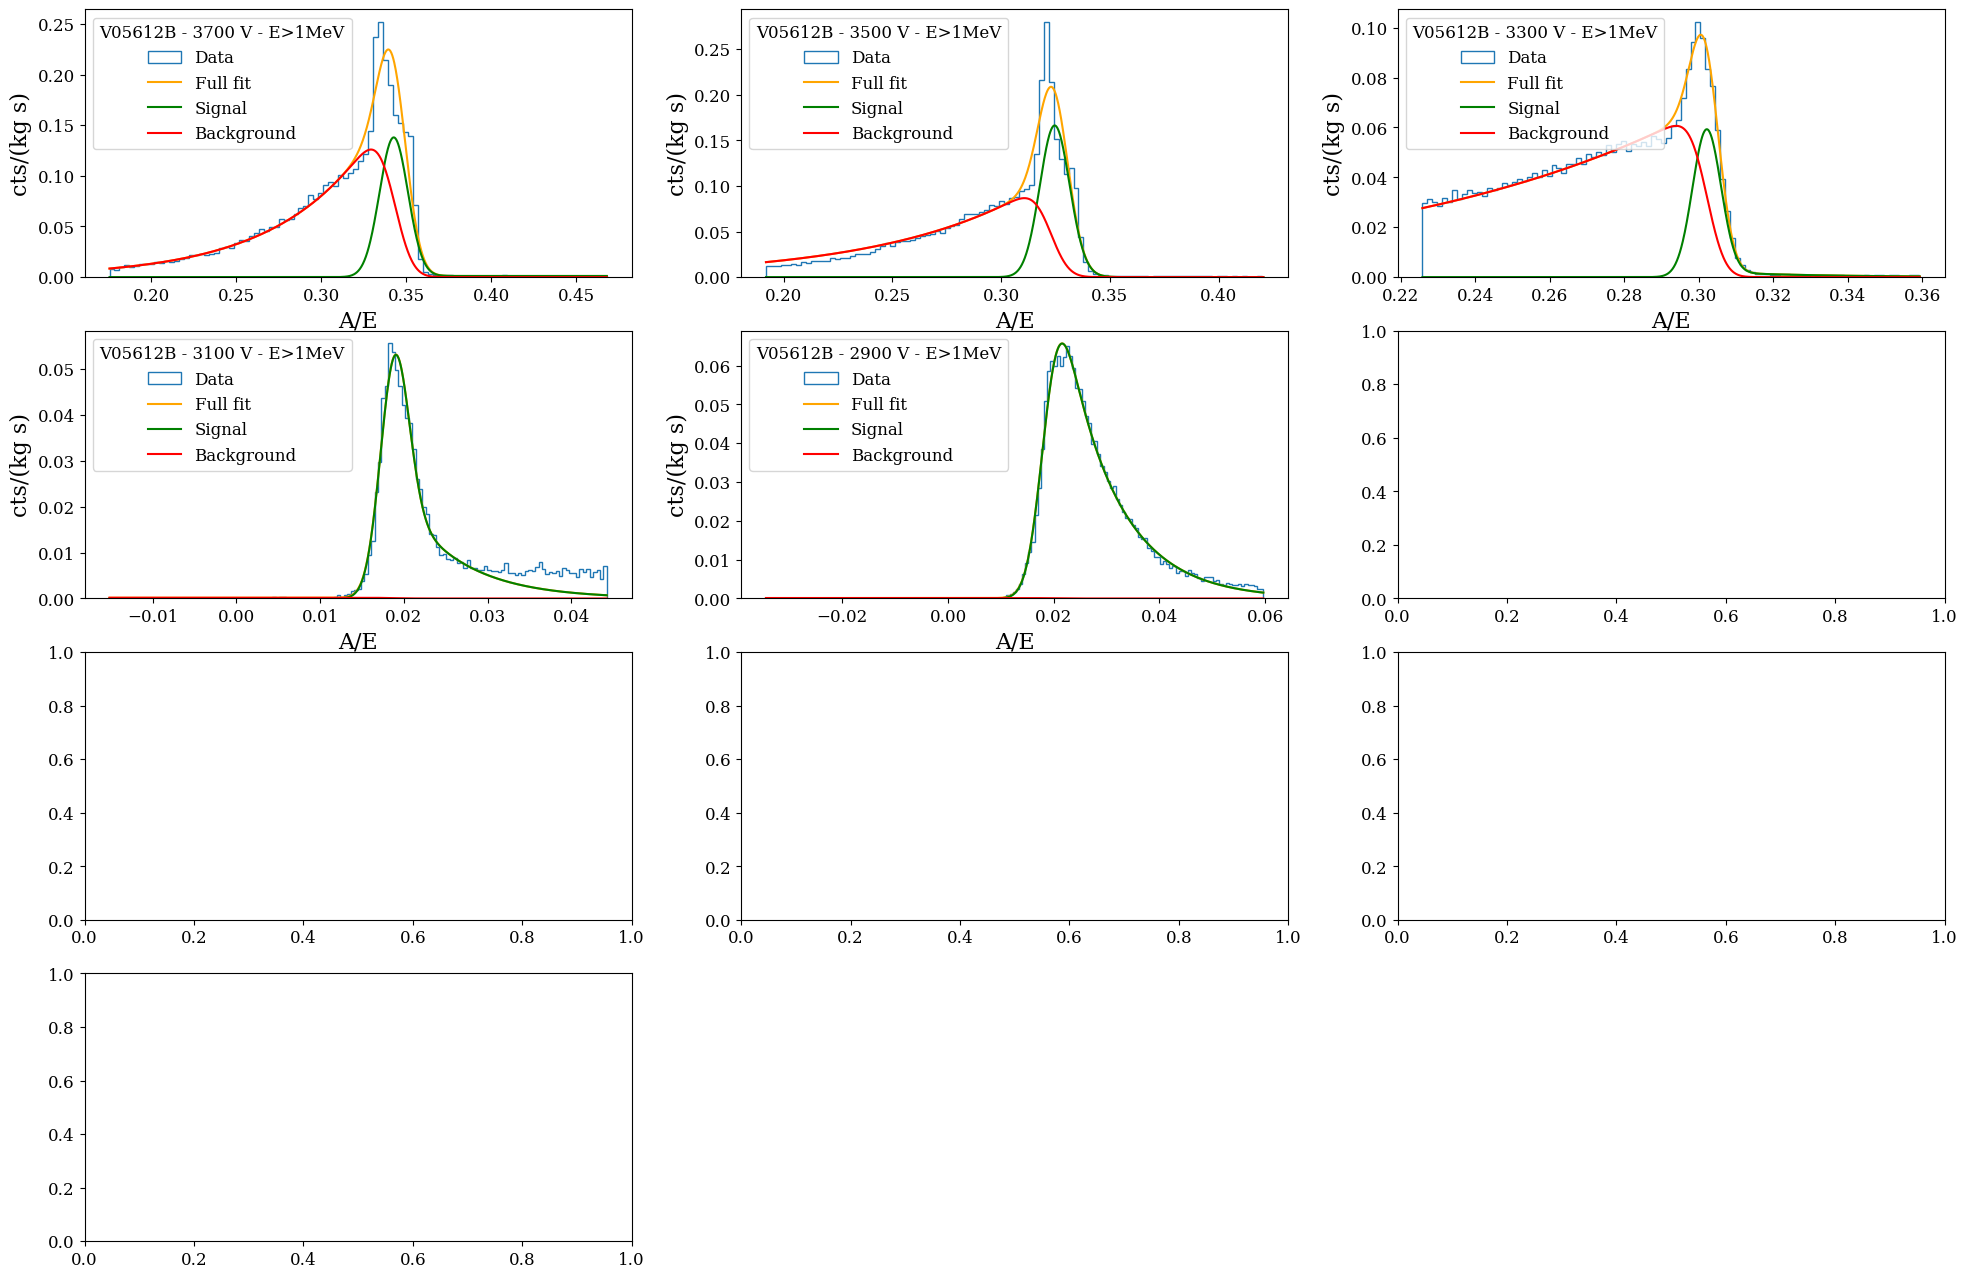

In [189]:
fig, axis = plt.subplots(nrows=4,ncols=3,figsize=(24,16), facecolor='white')
axis[3][1].axis('off')
axis[3][2].axis('off')

nscan = 0
for a_max_scan, energies_scan, exposures_scan, voltages_scan in zip(a_max[n_det],energies[n_det],exposures[n_det], voltages[n_det]):
    #if nscan>1: continue
    print('voltage', voltages_scan) 
    ax = axis.flat[nscan]
    aoe = a_max_scan/energies_scan
    print(np.isnan(a_max_scan).any())
    cut = (energies_scan>1000) & (aoe<1000)
    aoe = aoe[cut]
    par, err, migrad, _ = aoe_cal.unbinned_aoe_fit(aoe, pdf=pdf_fit, display=0)
    mu = par[1] 
    sigma = par[2]
    fmin = mu - 20 * sigma
    fmax = mu + 15 * sigma 
    print(fmin, fmax)
    xs = np.linspace(fmin, fmax, 1000)
    counts, bins, bars = ax.hist(
        aoe[(aoe < fmax) & (aoe > fmin)], bins=100, histtype="step", label="Data",  weights=np.ones_like(aoe[(aoe < fmax) & (aoe > fmin)])/exposures_scan
    )
    dx = np.diff(bins)
    tot = pdf_fit().pdf(xs, *par[:-1],False)
    tot_width=tot*dx[0]/exposures_scan
    sig, bkg = pdf_fit().pdf(xs, *par[:-1], True)

    ax.plot(xs, tot_width, label="Full fit")
    ax.plot(xs, sig *dx[0]/exposures_scan , label="Signal")
    ax.plot(xs, bkg *dx[0]/exposures_scan, label="Background")          
    ax.set_xlabel('A/E')
    ax.set_ylabel('cts/(kg s)')
    ax.legend(loc='upper left',title=f'{detectors[n_det]} - {voltages_scan:.0f} V - E>1MeV')

    #study of S/B
    if (SoB==True):            
        lower_range = mu-3*sigma
        upper_range = mu+3*sigma
        int_bkg = pgf.gauss_tail_integral(np.array([lower_range, upper_range]), mu, sigma, par[4])
        area_bkg = int_bkg[1]-int_bkg[0]
        SoB_max = max(sig)/max(bkg)
        SoB_3sigma = par[0]/(area_bkg*par[3])
        print('S/B max', SoB_max)
        print('S/B 3sigma',SoB_3sigma)
        SoB_max_array.append(SoB_max)
        SoB_3sigma_array.append(SoB_3sigma)
    print('\n')
    nscan+=1

In [ ]:
if SoB == True:
    voltages_scan=voltages[n_det]
    fig, axis = plt.subplots() 
    #axis.plot(voltages_scan[:3],SoB_3sigma_array[:3], c='b',marker='o',ms=8,label='S/B at 3sigma')
    axis.plot(voltages_scan[:3],SoB_max_array[:3], c='r',marker='o',ms=8,label='max(S)/max(B)')
    #axis.set_ylim([0, 2])
    axis.set_xlabel('HV [V]')
    axis.legend(title=f'{detectors[n_det]}', loc='upper left')
    axis.grid()
    axis.axhline(1.0,c='g',ls='-',lw=2)
    fig.show()

### Study on the asymmetry of A/E distribution with right/left bands (A/E tails)

voltage 3750.0
cut: >1MeV
half [0.00312498] [0.00250235]
quarter [0.00880319] [0.0035891]
eighth [0.01875024] [0.00451949]
cut: 1-1.4MeV
half [0.00403981] [0.00358468]
quarter [0.00726602] [0.00503179]
eighth [0.02052514] [0.00615138]
cut: 1.7-2MeV
half [0.00283669] [0.00232181]
quarter [0.00591302] [0.0032782]
eighth [0.01493518] [0.00401923]


voltage 3700.0
cut: >1MeV
half [0.00321395] [0.00261192]
quarter [0.00888987] [0.00371482]
eighth [0.01899803] [0.00464227]
cut: 1-1.4MeV
half [0.00406404] [0.00347204]
quarter [0.00750331] [0.00494523]
eighth [0.02063016] [0.0061397]
cut: 1.7-2MeV
half [0.00291271] [0.00250105]
quarter [0.00608156] [0.00350582]
eighth [0.01511791] [0.0042876]


voltage 3600.0
cut: >1MeV
half [0.0036219] [0.0028254]
quarter [0.01008898] [0.00403652]
eighth [0.02053964] [0.00506975]
cut: 1-1.4MeV
half [0.00427038] [0.00371398]
quarter [0.00828875] [0.00525424]
eighth [0.02240226] [0.00649828]
cut: 1.7-2MeV
half [0.00323174] [0.00260441]
quarter [0.00754502] [0.0

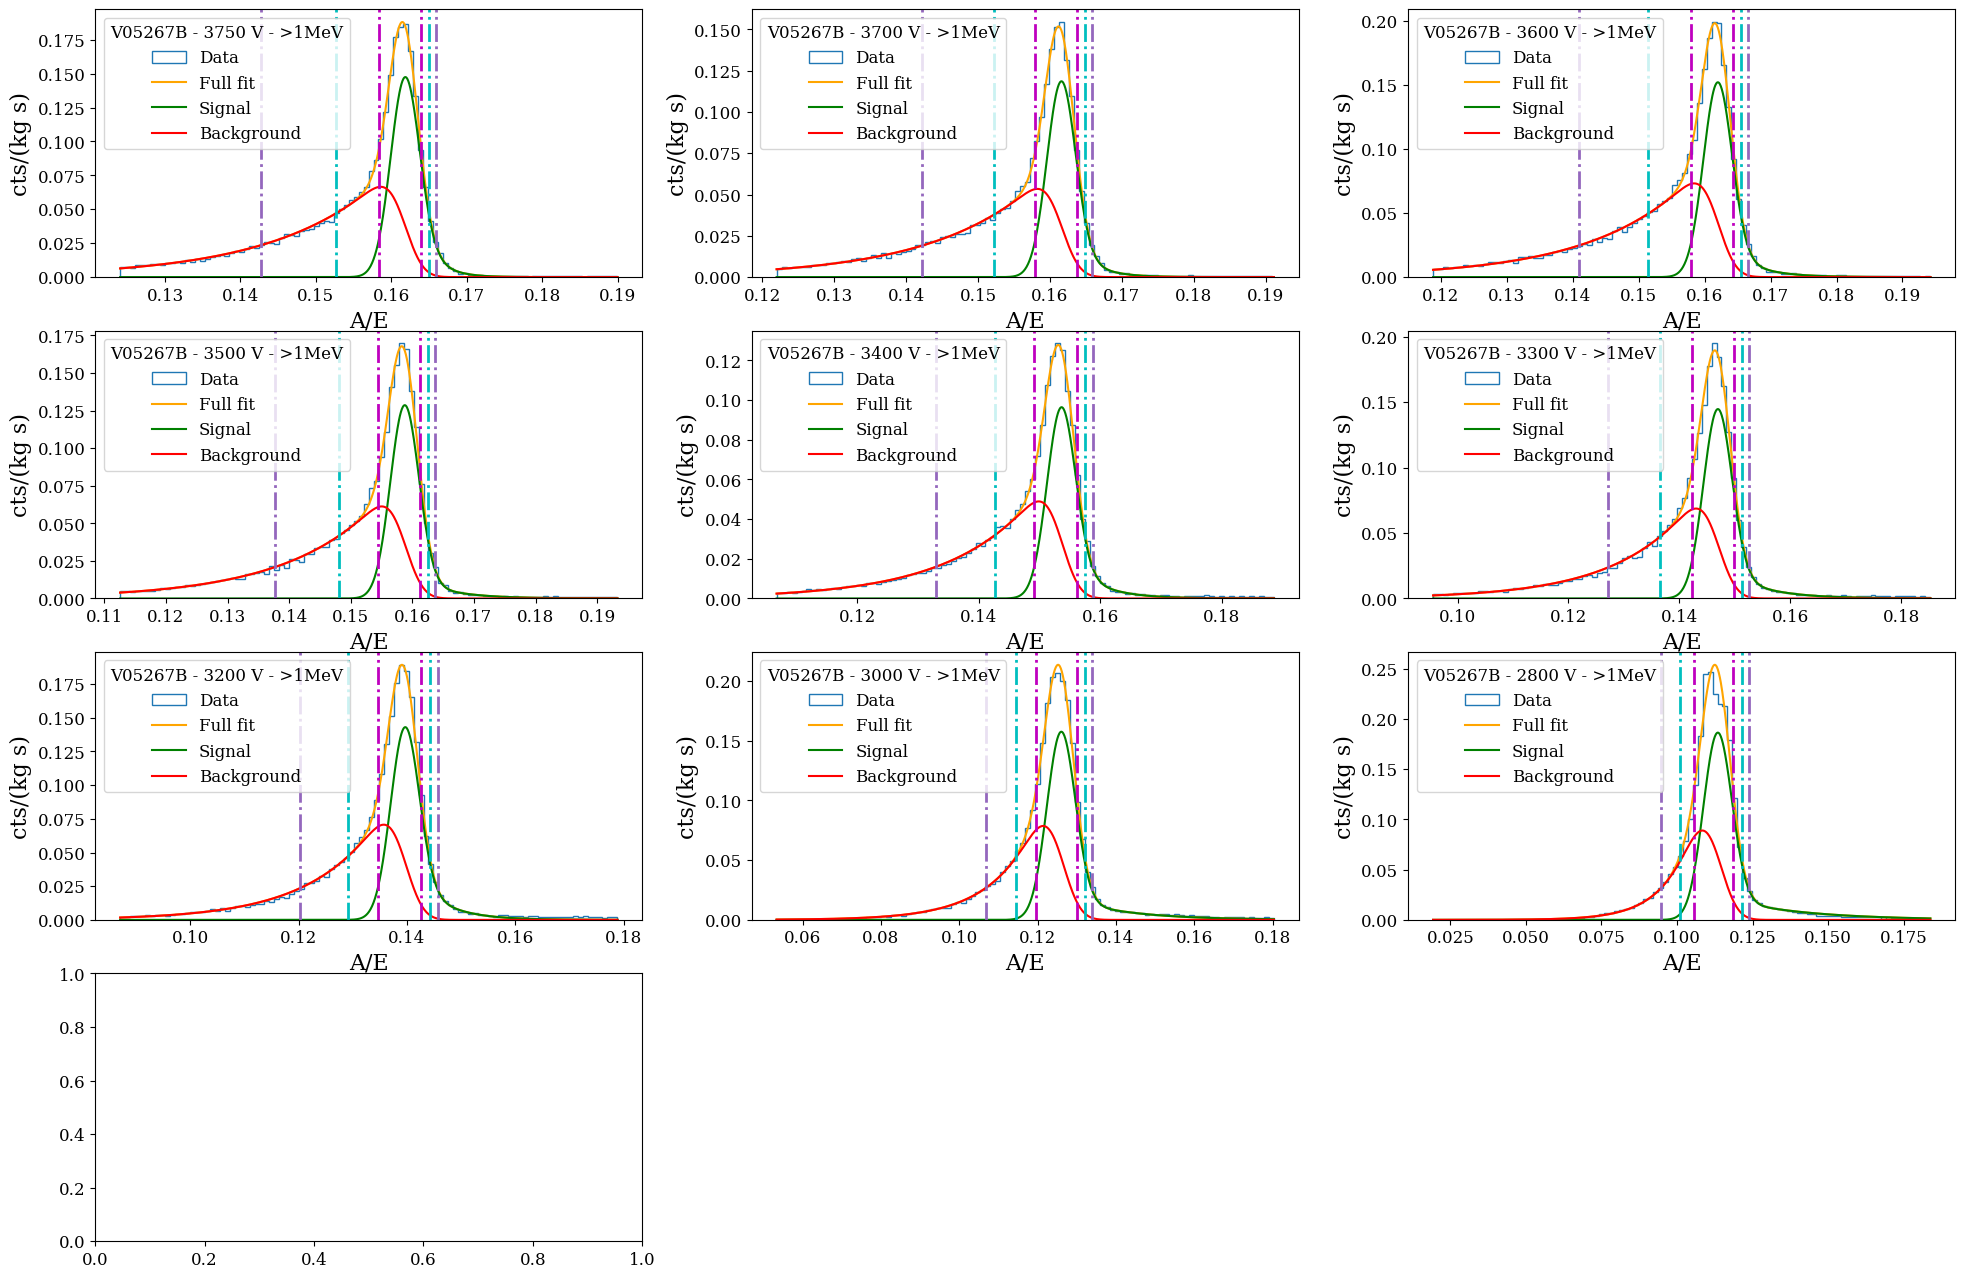

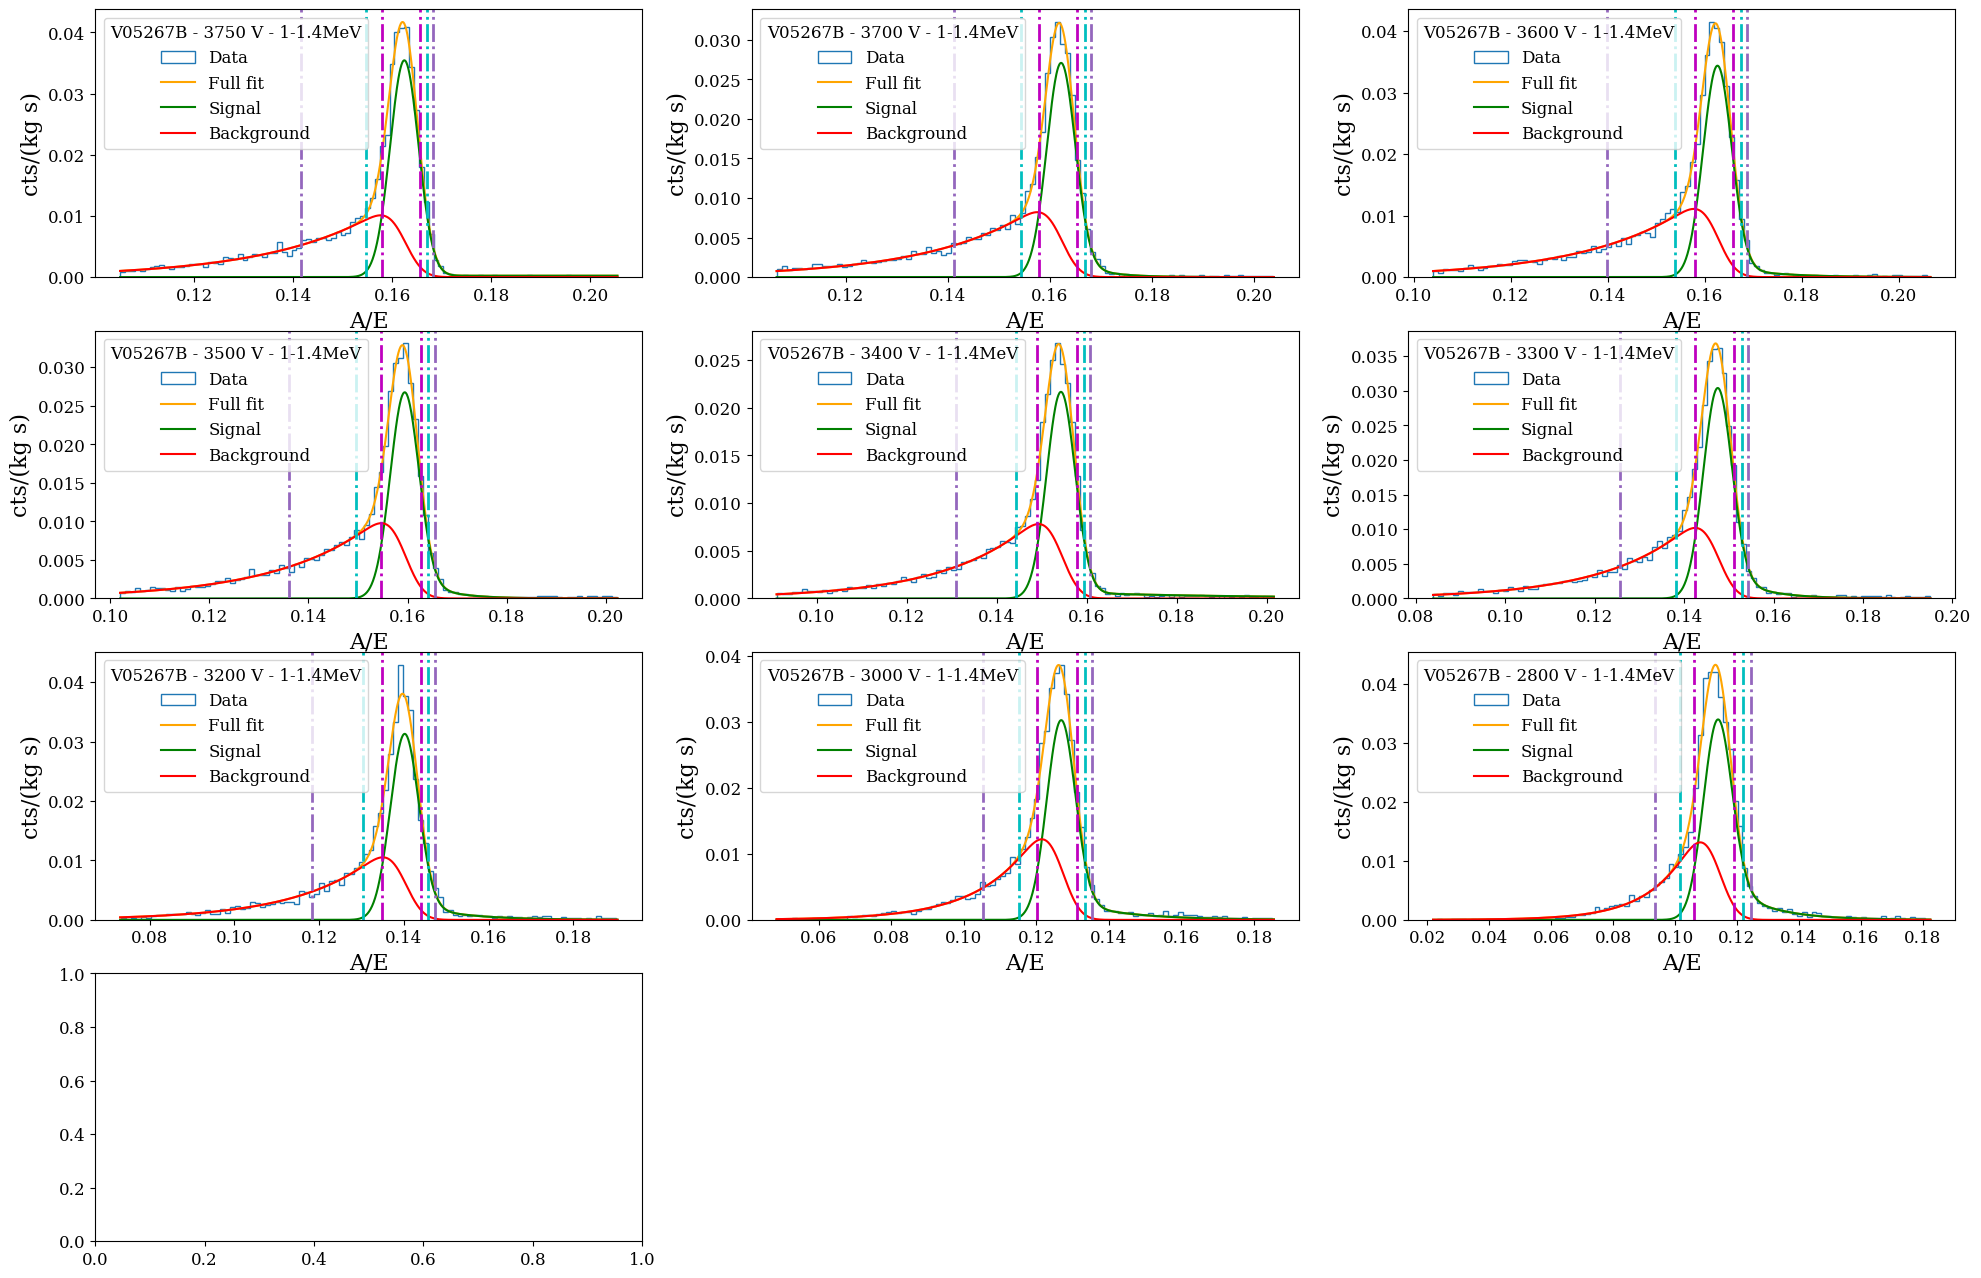

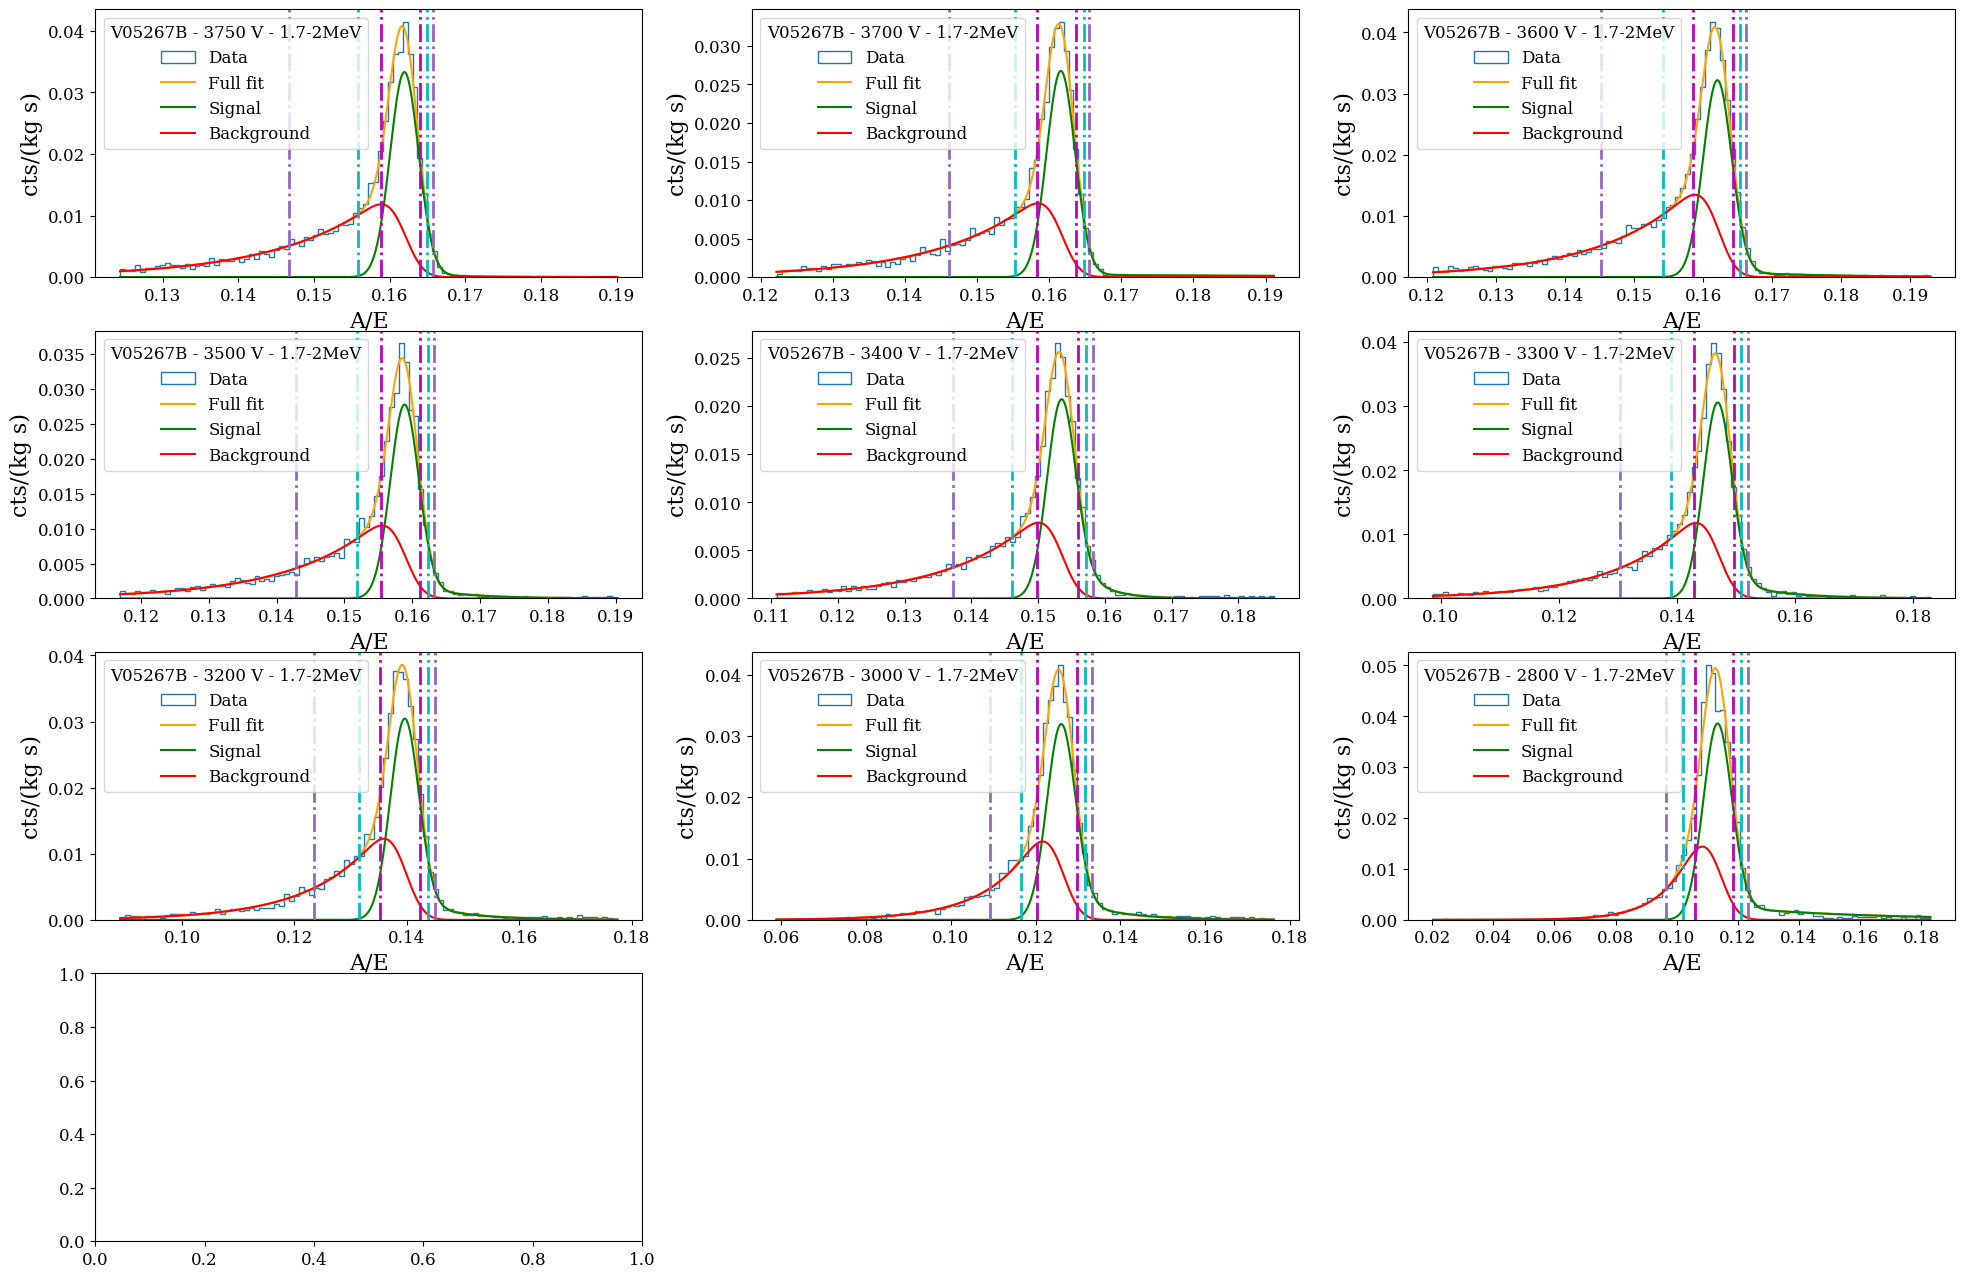

In [68]:
fig1, axis1 = plt.subplots(nrows=4,ncols=3,figsize=(24,16), facecolor='white')
fig2, axis2 = plt.subplots(nrows=4,ncols=3,figsize=(24,16), facecolor='white')
fig3, axis3 = plt.subplots(nrows=4,ncols=3,figsize=(24,16), facecolor='white')
axis1[3][1].axis('off')
axis1[3][2].axis('off')
axis2[3][1].axis('off')
axis2[3][2].axis('off')
axis3[3][1].axis('off')
axis3[3][2].axis('off')
figs = [fig1, fig2, fig3]
axes = [axis1, axis2, axis3]

peak_aoe, fwhm_aoe, fwhm_aoe_var = [[] for i in range(3)], [[] for i in range(3)],  [[] for i in range(3)]
peak_aoe_err, fwhm_aoe_var_err = [[] for i in range(3)],  [[] for i in range(3)]
width_halff, width_quarterr, width_eighthh = [[] for i in range(3)], [[] for i in range(3)], [[] for i in range(3)]
width_half_hist, width_quarter_hist = [[] for i in range(3)], [[] for i in range(3)]


nscan = 0
for a_max_scan, energies_scan, exposures_scan, voltages_scan in zip(a_max[n_det],energies[n_det],exposures[n_det], voltages[n_det]):
    print('voltage', voltages_scan)
    cuts_titles = ['>1MeV','1-1.4MeV', '1.7-2MeV']
    cuts = [(energies_scan>1000), ( (energies_scan>1000) & (energies_scan<1400) ),( (energies_scan>1700) & (energies_scan<2100))]
    for idx, cut in enumerate(cuts):
        print('cut:', cuts_titles[idx])
        ax1 = axis1.flat[nscan]
        ax2 = axis2.flat[nscan]
        ax3 = axis3.flat[nscan]
        axs = [ax1, ax2, ax3]
        ax = axs[idx]
        aoe = a_max_scan/energies_scan
        aoe = aoe[(cut) & (aoe<1000)]
        par, err, migrad, _ = aoe_cal.unbinned_aoe_fit(aoe, pdf=pdf_fit, display=0)
        mu = par[1]
        sigma = par[2]
        mu_err = err[1]
        sigma_err = err[2]
        peak_aoe[idx].append(mu)
        peak_aoe_err[idx].append(mu_err)
        fwhm_aoe[idx].append(sigma*2.355)
        fwhm_aoe_var[idx].append(sigma*2.355/mu)
        fwhm_aoe_var_err[idx].append(math.sqrt( pow(sigma/mu,2)*( pow(sigma_err/sigma,2) +pow(mu_err/mu,2) ))*2.355)          
        fmin = mu - 20 * sigma
        fmax = mu + 15 * sigma
        xs = np.linspace(fmin, fmax, 1000)
        counts, bins, bars = ax.hist(
            aoe[(aoe < fmax) & (aoe > fmin)], bins=100, histtype="step", label="Data",  weights=np.ones_like(aoe[(aoe < fmax) & (aoe > fmin)])/exposures_scan
        )
        dx = np.diff(bins)
        tot = pdf_fit().pdf(xs, *par[:-1],False)
        tot_width=tot*dx[0]/exposures_scan
        sig, bkg = pdf_fit().pdf(xs, *par[:-1], True)
        
        ax.plot(xs, tot_width, label="Full fit")
        ax.plot(xs, sig *dx[0]/exposures_scan , label="Signal")
        ax.plot(xs, bkg *dx[0]/exposures_scan, label="Background")          
        ax.set_xlabel('A/E')
        ax.set_ylabel('cts/(kg s)')
        ax.legend(loc='upper left',title=f'{detectors[n_det]} - {voltages_scan:.0f} V - {cuts_titles[idx]}')

        max_y=max(tot_width)
        x_max=xs[tot_width==max_y]
        x_interp_half_left = np.interp(max_y/2, tot_width[xs<x_max], xs[xs<x_max])
        x_interp_quarter_left = np.interp(max_y/4, tot_width[xs<x_max], xs[xs<x_max])
        x_interp_eighth_left = np.interp(max_y/8, tot_width[xs<x_max], xs[xs<x_max])
        tot_reverse=tot_width[xs>x_max]
        tot_reverse=tot_reverse[::-1]
        xs_reverse=xs[xs>x_max]
        xs_reverse=xs_reverse[::-1]
        x_interp_half_right = np.interp(max_y/2, tot_reverse, xs_reverse)
        x_interp_quarter_right = np.interp(max_y/4, tot_reverse, xs_reverse)
        x_interp_eighth_right = np.interp(max_y/8, tot_reverse, xs_reverse)
        width_half_right=(x_interp_half_right-x_max)
        width_half_left=(x_max-x_interp_half_left)
        width_quarter_right=(x_interp_quarter_right-x_max)
        width_quarter_left=(x_max-x_interp_quarter_left)
        width_eighth_right=(x_interp_eighth_right-x_max)
        width_eighth_left=(x_max-x_interp_eighth_left)
        width_half_diff=(width_half_left-width_half_right)/(x_max*(width_half_right+width_half_left))
        width_quarter_diff=(width_quarter_left-width_quarter_right)/(x_max*(width_quarter_right+width_quarter_left))
        width_eighth_diff=(width_eighth_left-width_eighth_right)/(x_max*(width_eighth_right+width_eighth_left))
        width_halff[idx].append(width_half_diff[0])
        width_quarterr[idx].append(width_quarter_diff[0])
        width_eighthh[idx].append(width_eighth_diff[0])

        ax.axvline(x_interp_half_left,c='m',ls='-.',lw=2)
        ax.axvline(x_interp_half_right,c='m',ls='-.',lw=2)
        ax.axvline(x_interp_quarter_left,c='c',ls='-.',lw=2)
        ax.axvline(x_interp_quarter_right,c='c',ls='-.',lw=2)
        ax.axvline(x_interp_eighth_left,c='tab:purple',ls='-.',lw=2)
        ax.axvline(x_interp_eighth_right,c='tab:purple',ls='-.',lw=2)

        print("half", width_half_left, width_half_right)
        print("quarter", width_quarter_left, width_quarter_right)
        print("eighth", width_eighth_left, width_eighth_right)
    print('\n')
    nscan+=1
    
if save_fig == True:
    savefig(fig1, detectors[n_det], "AoE_spectrum_E>1MeV")
    savefig(fig2, detectors[n_det], "AoE_spectrum_1MeV<E<1.4MeV")
    savefig(fig3, detectors[n_det], "AoE_spectrum_1.7MeV<E<2.1MeV")

In [69]:
#take the values from the old HV scan

with open(f'old_scan/{detectors[n_det]}.json', "r") as outfile: 
    scan_old = json.load(outfile)

voltages_old=list(map(float, scan_old[detectors[n_det]].keys()))


voltages_tot=list(voltages[0]) + voltages_old

peak_aoe_tot = [[],[],[]]
peak_aoe_err_tot = [[],[],[]]

fwhm_aoe_var_tot = [[],[],[]]
fwhm_aoe_var_err_tot = [[],[],[]]

width_halff_tot = [[],[],[]]
width_quarterr_tot = [[],[],[]]
width_eighthh_tot = [[],[],[]]

for i in range(len(peak_aoe)):
    peak_aoe_new = peak_aoe[i]
    peak_aoe_err_new = peak_aoe_err[i]
    fwhm_aoe_var_new = fwhm_aoe_var[i]
    fwhm_aoe_var_err_new = fwhm_aoe_var_err[i]
    width_halff_new = width_halff[i]
    width_quarterr_new = width_quarterr[i]
    width_eighthh_new = width_eighthh[i]
    
    peak_aoe_old=[]
    peak_aoe_err_old=[]
    fwhm_aoe_var_old=[]
    fwhm_aoe_var_err_old=[]
    width_halff_old=[]
    width_quarterr_old=[]
    width_eighthh_old=[]
    for v in scan_old[detectors[n_det]].keys():
        peak_aoe_old_single = list(scan_old[detectors[n_det]][v][cuts_titles[i]].values())[0]
        peak_aoe_old.append(peak_aoe_old_single)
        peak_aoe_err_old_single = list(scan_old[detectors[n_det]][v][cuts_titles[i]].values())[1]
        peak_aoe_err_old.append(peak_aoe_err_old_single)
        fwhm_aoe_var_old_single = list(scan_old[detectors[n_det]][v][cuts_titles[i]].values())[2]
        fwhm_aoe_var_old.append(fwhm_aoe_var_old_single)
        fwhm_aoe_var_err_old_single = list(scan_old[detectors[n_det]][v][cuts_titles[i]].values())[3]
        fwhm_aoe_var_err_old.append(fwhm_aoe_var_err_old_single)
        width_halff_old_single = list(scan_old[detectors[n_det]][v][cuts_titles[i]].values())[4]
        width_halff_old.append(width_halff_old_single)
        width_quarterr_old_single = list(scan_old[detectors[n_det]][v][cuts_titles[i]].values())[5]
        width_quarterr_old.append(width_halff_old_single)
        width_eighthh_old_single = list(scan_old[detectors[n_det]][v][cuts_titles[i]].values())[6]
        width_eighthh_old.append(width_halff_old_single)

    peak_aoe_tot[i] = peak_aoe_new + peak_aoe_old
    peak_aoe_err_tot[i] = peak_aoe_err_new + peak_aoe_err_old
    fwhm_aoe_var_tot[i] = fwhm_aoe_var_new + fwhm_aoe_var_old
    fwhm_aoe_var_err_tot[i] = fwhm_aoe_var_err_new + fwhm_aoe_var_err_old
    width_halff_tot[i] = width_halff_new + width_halff_old
    width_quarterr_tot[i] = width_quarterr_new + width_quarterr_old
    width_eighthh_tot[i] = width_eighthh_new + width_eighthh_old


peak_aoe = peak_aoe_tot
peak_aoe_err = peak_aoe_err_tot
fwhm_aoe_var = fwhm_aoe_var_tot
fwhm_aoe_var_err = fwhm_aoe_var_err_tot
width_halff = width_halff_tot
width_quarterr = width_quarterr_tot
width_eighthh = width_eighthh_tot


In [85]:
print(len(voltages_tot))
#print(voltages)
voltages[0]=voltages_tot
print(voltages[0])
#voltages[0][4] = 2800.0

20
[3750.0, 3700.0, 3600.0, 3500.0, 3400.0, 3300.0, 3200.0, 3000.0, 2800.0, 2600.0, 4700.0, 4500.0, 4300.0, 4100.0, 3800.0, 3500.0, 3200.0, 2900.0, 2500.0, 2100.0]


In [81]:
peak_aoe[0][8:]

[0.11332691318450482,
 0.4395193664913159,
 0.4215912852443579,
 0.41460870576558606,
 0.4175534257053464,
 0.40317096493422105,
 0.38473387045477,
 0.3605074645635938,
 0.32573028760005246,
 0.24053959056802035,
 0.10915430117507417]

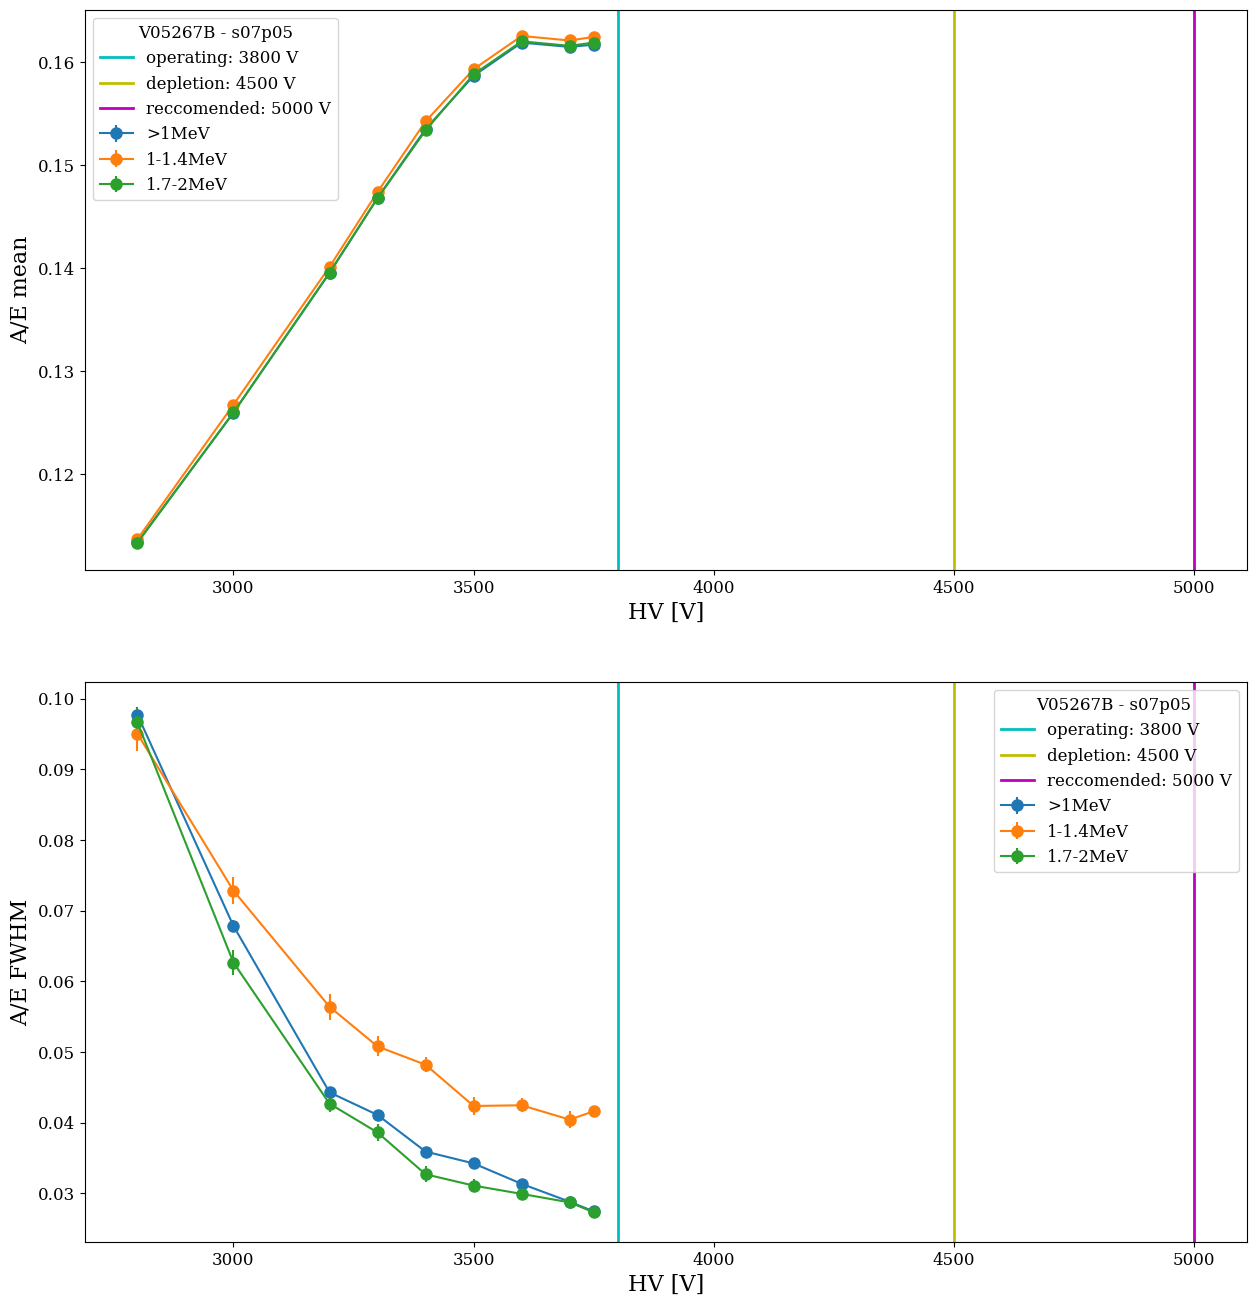

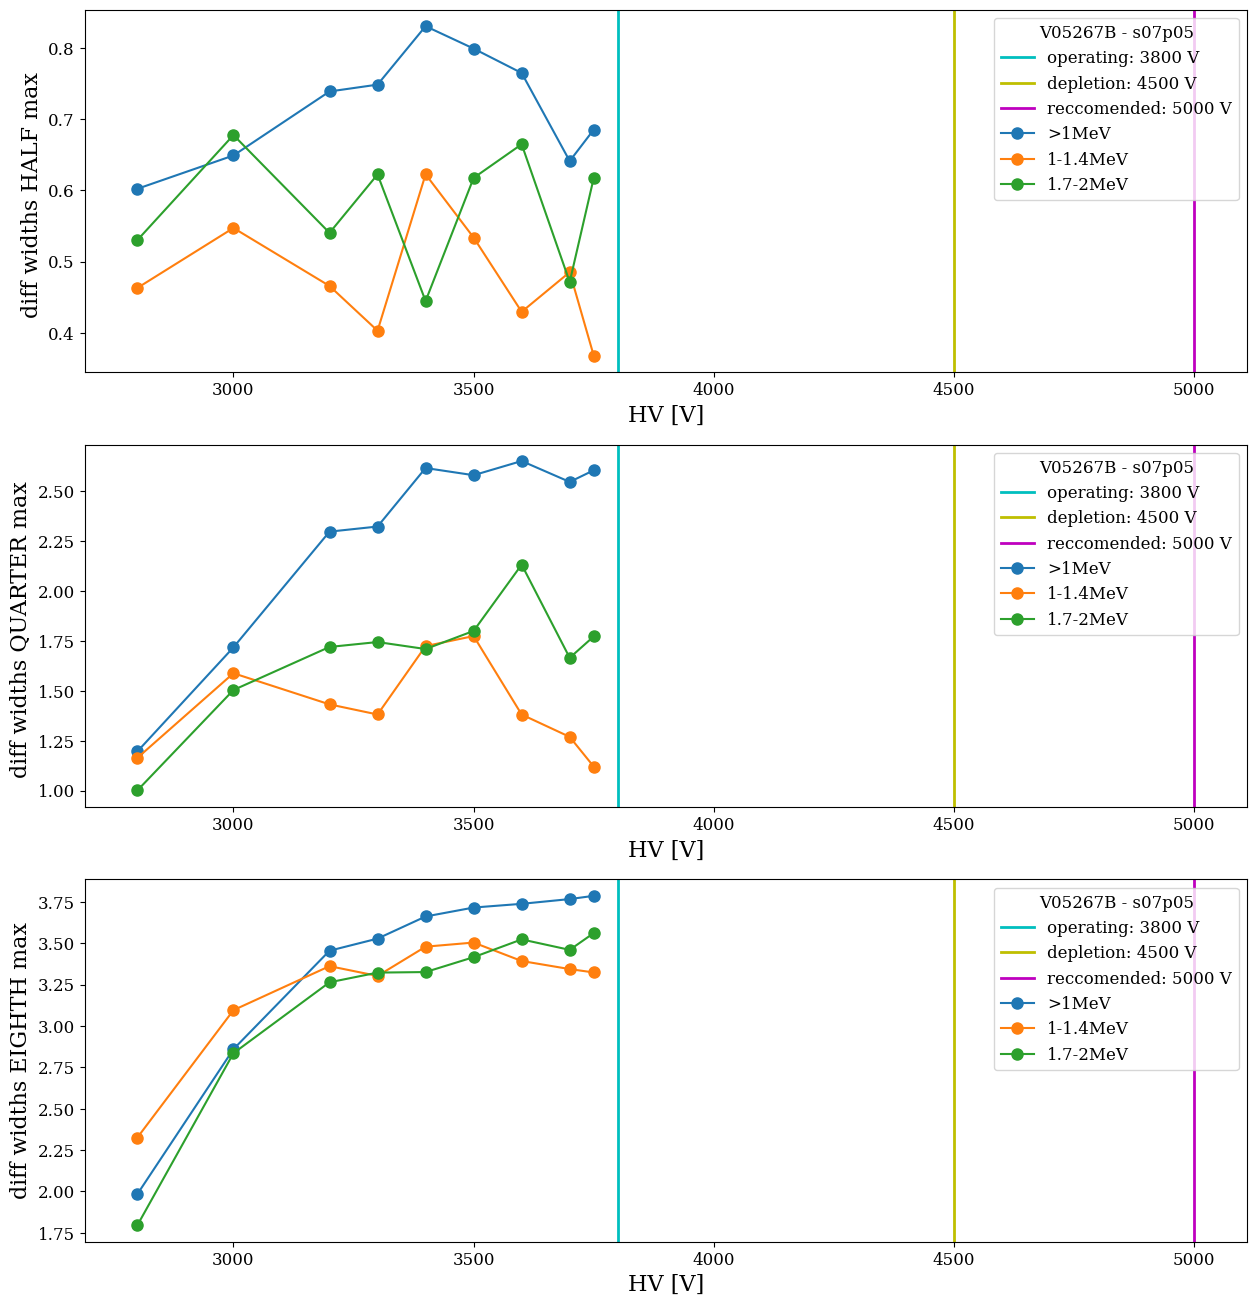

In [86]:
fig_summary, axis_summary = plt.subplots(nrows=2, figsize=(15,16), facecolor='white') 
fig_width, axis_width = plt.subplots(nrows=3, figsize=(15,16), facecolor='white')    

col = ['tab:blue','tab:orange','tab:green']
operating = float(operating_all[n_volt])
depletion = float(depletion_all[n_volt])
reccomended = float(reccomended_all[n_volt])

for i, cut_title in enumerate(cuts_titles):
    voltages_array, mu_pos, sigma_pos = np.array(voltages[0][:nint]), np.array(peak_aoe[i][:nint]), np.array(fwhm_aoe_var[i][:nint])
    mu_pos_err, sigma_pos_err = np.array(peak_aoe_err[i][:nint]), np.array(fwhm_aoe_var_err[i][:nint])
    width_half,  width_quarter,  width_eighth= np.array(width_halff[i][:nint]) ,np.array(width_quarterr[i][:nint]), np.array(width_eighthh[i][:nint])
    if i ==0:
        axis_summary[0].axvline(operating+1,c='c',ls='-',lw=2,label=f'operating: {operating:.0f} V')
        axis_summary[1].axvline(operating+1,c='c',ls='-',lw=2,label=f'operating: {operating:.0f} V')
        axis_width[0].axvline(operating+1,c='c',ls='-',lw=2,label=f'operating: {operating:.0f} V')
        axis_width[1].axvline(operating+1,c='c',ls='-',lw=2,label=f'operating: {operating:.0f} V')
        axis_width[2].axvline(operating+1,c='c',ls='-',lw=2,label=f'operating: {operating:.0f} V')
        if manufacturer_hv:
            axis_summary[0].axvline(depletion-1,c='y',ls='-',lw=2,label=f'depletion: {depletion:.0f} V')
            axis_summary[0].axvline(reccomended,c='m',ls='-',lw=2,label=f'reccomended: {reccomended:.0f} V')
            axis_summary[1].axvline(depletion-1,c='y',ls='-',lw=2,label=f'depletion: {depletion:.0f} V')
            axis_summary[1].axvline(reccomended,c='m',ls='-',lw=2,label=f'reccomended: {reccomended:.0f} V')
            axis_width[0].axvline(depletion-1,c='y',ls='-',lw=2,label=f'depletion: {depletion:.0f} V')
            axis_width[0].axvline(reccomended,c='m',ls='-',lw=2,label=f'reccomended: {reccomended:.0f} V')
            axis_width[1].axvline(depletion-1,c='y',ls='-',lw=2,label=f'depletion: {depletion:.0f} V')
            axis_width[1].axvline(reccomended,c='m',ls='-',lw=2,label=f'reccomended: {reccomended:.0f} V')
            axis_width[2].axvline(depletion-1,c='y',ls='-',lw=2,label=f'depletion: {depletion:.0f} V')
            axis_width[2].axvline(reccomended,c='m',ls='-',lw=2,label=f'reccomended: {reccomended:.0f} V')
    
    axis_summary[0].errorbar(voltages_array[:9],mu_pos[:9],mu_pos_err[:9],c=col[i] ,marker='o',ms=8,label=f'{cut_title}')
    #axis_summary[0].errorbar(voltages_array[10:],mu_pos[9:],mu_pos_err[9:],c=col[i] ,marker='o',ms=8, ls='--',markerfacecolor='none')
    axis_summary[0].set_xlabel('HV [V]')
    axis_summary[0].set_ylabel('A/E mean')
    axis_summary[0].legend(title=f'{detectors[n_det]} - s{string:02}p{position:02}', loc='upper left')

    axis_summary[1].errorbar(voltages_array[:9],sigma_pos[:9],sigma_pos_err[:9],c=col[i], marker='o',ms=8,label=f'{cut_title}')
    #axis_summary[1].errorbar(voltages_array[10:],sigma_pos[9:],sigma_pos_err[9:],c=col[i],marker='o',ms=8, ls='--', markerfacecolor='none')
    axis_summary[1].set_xlabel('HV [V]')
    axis_summary[1].set_ylabel('A/E FWHM')
    axis_summary[1].legend(title=f'{detectors[n_det]} - s{string:02}p{position:02} ',loc='upper right')


    axis_width[0].plot(voltages_array[:9],width_half[:9], c=col[i] ,marker='o',ms=8,label=f'{cut_title}')
    #axis_width[0].plot(voltages_array[10:],width_half[9:], c=col[i] ,marker='o',ms=8, ls='--', markerfacecolor='none')
    axis_width[0].set_xlabel('HV [V]')
    axis_width[0].set_ylabel('diff widths HALF max ')
    axis_width[0].legend(title=f'{detectors[n_det]} - s{string:02}p{position:02}', loc='upper right')

    axis_width[1].plot(voltages_array[:9],width_quarter[:9],c=col[i] ,marker='o',ms=8,label=f'{cut_title}')
    #axis_width[1].plot(voltages_array[10:],width_quarter[9:],c=col[i] ,marker='o',ms=8, ls='--', markerfacecolor='none')
    axis_width[1].set_xlabel('HV [V]')
    axis_width[1].set_ylabel('diff widths QUARTER max ')
    axis_width[1].legend(title=f'{detectors[n_det]} - s{string:02}p{position:02}', loc='upper right')
    
    axis_width[2].plot(voltages_array[:9],width_eighth[:9],c=col[i] ,marker='o',ms=8,label=f'{cut_title}')
    #axis_width[2].plot(voltages_array[10:],width_eighth[9:],c=col[i] ,marker='o',ms=8, ls='--', markerfacecolor='none')
    axis_width[2].set_xlabel('HV [V]')
    axis_width[2].set_ylabel('diff widths EIGHTH max')
    axis_width[2].legend(title=f'{detectors[n_det]} - s{string:02}p{position:02}', loc='upper right') 

if save_fig == True:
    savefig(fig_summary, detectors[n_det], "AoE_mean_FWHM")
    savefig(fig_width, detectors[n_det], "AoE_asymmetry")